In [1]:
import pandas as pd
import os 
import random
import subprocess

import dask.dataframe as dd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

import pandas as pd
import scipy.stats
import numpy as np
import sys, argparse
from scipy.stats import norm
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

In [2]:
#maf = pd.read_csv('../key_files/maf_all_samples.csv')

In [3]:
#maf.columns = ['MAF']

In [4]:
wd = '/carnegie/nobackup/scratch/tbellagio/gea_grene-net/lfmm_full/lfmm_fullresults_all_k/'

In [5]:
biovar = 'bio1'

In [6]:
#pvalues_file = f'/carnegie/nobackup/scratch/tbellagio/gea_grene-net/lfmm_full/lfmm_fullresults_all_k/lfmm_{biovar}_k25_results.csv'

In [7]:
#lfmm = pd.concat([lfmm, maf['MAF']],axis=1)

In [8]:
#lfmm.to_csv('lfmm_results_all_samples_k25_wmaf.csv',index=None)

In [9]:
path = '/carnegie/nobackup/scratch/tbellagio/gea_grene-net/wza'

In [ ]:
['id', 'pos', 'chrom', 'K_tau', 'K_tau_p', 'MAF', 'block']

In [683]:
## create a dir 

#        --sample_snps 1729 \
#        --resample 50 \
# create sbatch files to submit on cedar server
shfiles = []

seed = random.randint(1,100000000)
file = 'wza.sh'
cmd = f'python general_WZA_script_mod_polynomial_order7.py \
        --correlations ../kendall_tau/kendall_corr_bio1.csv \
        --summary_stat K_tau_p \
        --window block \
        --output wza_results_lfmm_bio1_poly7check.csv \
        --sep ","'
text = f'''#!/bin/bash
#SBATCH --job-name=wza
#SBATCH --time=1:00:00  # Time limit set to 4 days
#SBATCH --ntasks=1
#SBATCH --mem-per-cpu=30gb
#SBATCH --output=wza_%j.out
#SBATCH --mail-user=tbellagio@carnegiescience.edu
#SBATCH --mail-type=FAIL

module load python/3.11_conda
conda activate /home/tbellagio/miniforge3/envs/pipeline_snakemake
export LD_LIBRARY_PATH="/home/tbellagio/miniforge3/envs/run_baypass/lib:$LD_LIBRARY_PATH"
cd /carnegie/nobackup/scratch/tbellagio/gea_grene-net/wza
{cmd}


'''
with open(file, 'w') as o:
    o.write("%s" % text)
shfiles.append(file)

In [684]:
## now run the shfiles
for shfile in shfiles:
    # Submit each sbatch script to the SLURM scheduler
    subprocess.run(["sbatch", shfile], check=True)

Submitted batch job 31919


In [682]:
biovar = 'bio1'

In [765]:
kendall_corr_bio1 = pd.read_csv('../kendall_tau/kendall_corr_bio1.csv')

In [766]:
kendall_corr_bio1

,id,pos,chrom,K_tau,K_tau_p,MAF,block
0,1_346,346,1,-0.012582,0.738525,0.281796,1_0
1,1_353,353,1,0.064274,0.088163,0.074906,1_0
2,1_363,363,1,-0.016840,0.655039,0.104640,1_0
3,1_395,395,1,0.112836,0.002770,0.065442,1_0
4,1_396,396,1,0.112836,0.002770,0.065442,1_0
...,...,...,...,...,...,...,...
1054569,5_26975078,26975078,5,-0.093223,0.013397,0.161471,5_3110
1054570,5_26975121,26975121,5,0.016496,0.661665,0.072238,5_3110
1054571,5_26975148,26975148,5,0.016496,0.661665,0.072238,5_3110
1054572,5_26975272,26975272,5,-0.002340,0.950499,0.474359,5_3110


In [771]:
import numpy as np
import pandas as pd
from scipy.stats import chi2

# Fisher's method function to aggregate p-values
def fishers_method(p_values):
    """
    Applies Fisher's method to combine p-values into a single p-value.
    
    Parameters:
    p_values (list or np.array): A list or array of p-values for SNPs in a window.
    
    Returns:
    float: Aggregated p-value using Fisher's method.
    """
    # Ensure all p-values are above 0 (log of 0 is undefined)
    p_values = np.clip(p_values, 1e-10, 1)  # Avoid taking log(0)
    
    # Calculate the test statistic
    chi_square_stat = -2 * np.sum(np.log(p_values))
    
    # Degrees of freedom (2 * number of p-values)
    df = 2 * len(p_values)
    
    # Compute the p-value from the chi-square distribution
    combined_p_value = 1 - chi2.cdf(chi_square_stat, df)
    
    return combined_p_value

# Assuming your DataFrame is named `df`
# Group by 'block' and apply Fisher's method to the 'K_tau_p' column
aggregated_pvals = kendall_corr_bio1.groupby('block')['K_tau_p'].apply(fishers_method)

# Convert the aggregated p-values into a DataFrame
aggregated_pvals_df = pd.DataFrame(aggregated_pvals).reset_index()

In [784]:
fisher = aggregated_pvals.reset_index()

In [786]:
fisher.columns = ['block', 'fisher_agg']

In [751]:
kendall_corr_bio1_top = kendall_corr_bio1.groupby('block')['K_tau_p'].min().reset_index()

In [717]:
wza_df = pd.read_csv('before_filtering_wza_df.csv')

In [745]:
wza_df

,Unnamed: 0,gene,SNPs,hits,Z,top_candidate_p,scale_old_poly,mean_old_poly,Z_pVal_old_poly,scale_newpoly,mean_newpoly,Z_pVal_newpoly,Z_no_spline
0,0,1_0,198,0,-5.382798,1.0,6.117179,-0.265433,0.798579,5.862682,-0.146079,0.814133,1.000000
1,1,1_1,3,0,-1.266673,1.0,1.375660,-0.076370,0.806552,1.598254,-0.120764,0.763306,0.897364
2,2,1_10,22,0,-1.211412,1.0,2.328407,-0.165085,0.673419,2.129878,-0.130758,0.694055,0.887131
3,3,1_100,53,0,3.029274,1.0,3.567251,-0.258689,0.178341,2.940168,-0.143120,0.140297,0.001226
4,4,1_1000,9,0,2.030071,1.0,1.694126,-0.107369,0.103533,1.769058,-0.124125,0.111668,0.021175
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16651,16651,5_995,39,0,-4.429697,1.0,3.052121,-0.223305,0.915927,2.582873,-0.138125,0.951698,0.999995
16652,16652,5_996,3,0,-0.225149,1.0,1.375660,-0.076370,0.543062,1.598254,-0.120764,0.526037,0.589068
16653,16653,5_997,27,0,-2.670487,1.0,2.553171,-0.184112,0.834932,2.265314,-0.133076,0.868668,0.996213
16654,16654,5_998,7,0,-2.067785,1.0,1.589839,-0.097358,0.892399,1.712425,-0.123026,0.871954,0.980670


In [718]:
wza_df.shape

(16656, 6)

In [719]:
wza_t = wza_df[~wza_df.Z.isnull()].reset_index()
wza_s = wza_t.sort_values('SNPs')

In [720]:
wza_t.shape

(16656, 7)

In [721]:
roller=50
minEntries=5
chosen_degree=7

rolled_Z_vars = wza_s.Z.rolling(window=roller, min_periods=minEntries).var()
masking_array = ~rolled_Z_vars.isnull()
rolled_Z_sd = np.sqrt(rolled_Z_vars)[masking_array]
rolled_Z_means = wza_s.Z.rolling(window=roller, min_periods=minEntries).mean()[masking_array]
rolled_mean_SNP_number = wza_s.SNPs.rolling(window=roller, min_periods=minEntries).mean()[masking_array]

In [722]:
if rolled_Z_vars.isnull().any():
    print(f"WARNING: Rolling window calculation resulted in NaN for some windows.")

# Generating weights for polynomial function with degree=2 - standard deviation
sd_weights = np.polyfit(rolled_mean_SNP_number, rolled_Z_sd, deg=chosen_degree)
sd_polynomial_model = np.poly1d(sd_weights)

# Generating weights for polynomial function with degree=2 - mean
mean_weights = np.polyfit(rolled_mean_SNP_number, rolled_Z_means, deg=chosen_degree)
mean_polynomial_model = np.poly1d(mean_weights)

sd_predictions = sd_polynomial_model(wza_df["SNPs"])
mean_predictions = mean_polynomial_model(wza_df["SNPs"])

In [723]:
wza_df['scale_old_poly'] = sd_predictions

wza_df['mean_old_poly'] = mean_predictions

In [724]:
wza_p_values = [1 - norm.cdf(wza_df["Z"][i], loc=mean_predictions[i], scale=sd_predictions[i]) for i in range(wza_df.shape[0])]
wza_df["Z_pVal_old_poly"] = wza_p_values

In [725]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [726]:
# Import necessary libraries
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
import numpy as np

# Example with degree 3 polynomial
model_sd = make_pipeline(PolynomialFeatures(3),  Ridge(alpha=0.5))

# Reshape rolled_mean_SNP_number to be 2D
X_train = np.array(rolled_mean_SNP_number).reshape(-1, 1)
y_train = rolled_Z_sd  # Assuming rolled_Z_sd is already a 1D array

# Fit the model
model_sd.fit(X_train, y_train)

# When predicting, also reshape the input
X_predict = np.array(wza_df["SNPs"]).reshape(-1, 1)
sd_predictions = model_sd.predict(X_predict)

# Example with degree 3 polynomial
model_mean = make_pipeline(PolynomialFeatures(3), Ridge(alpha=0.5))

# Reshape rolled_mean_SNP_number to be 2D
X_train = np.array(rolled_mean_SNP_number).reshape(-1, 1)
y_train = rolled_Z_means  # Assuming rolled_Z_sd is already a 1D array

# Fit the model
model_mean.fit(X_train, y_train)

# When predicting, also reshape the input
X_predict = np.array(wza_df["SNPs"]).reshape(-1, 1)
mean_predictions = model_mean.predict(X_predict)



/home/tbellagio/miniforge3/envs/pipeline_snakemake/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.96424e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/tbellagio/miniforge3/envs/pipeline_snakemake/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.96424e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [727]:
wza_df['scale_newpoly'] = sd_predictions

wza_df['mean_newpoly'] = mean_predictions

In [728]:
wza_p_values = [1 - norm.cdf(wza_df["Z"][i], loc=mean_predictions[i], scale=sd_predictions[i]) for i in range(wza_df.shape[0])]
wza_df["Z_pVal_newpoly"] = wza_p_values

In [729]:
wza_p_values = [1 - norm.cdf(wza_df["Z"][i]) for i in range(wza_df.shape[0])]
wza_df["Z_no_spline"] = wza_p_values

In [756]:
wza_df = wza_df.merge(kendall_corr_bio1_top, left_on='gene', right_on = 'block')

In [ ]:
aggregated_pvals_fisher

In [787]:
wza_df = wza_df.merge(fisher, left_on='gene', right_on = 'block')

In [788]:
wza_df

,Unnamed: 0,gene,SNPs,hits,Z,top_candidate_p,scale_old_poly,mean_old_poly,Z_pVal_old_poly,scale_newpoly,...,id,pos,chrom,K_tau,K_tau_p_y,MAF,block_y,K_tau_p_agg,block,fisher_agg
0,0,1_0,198,0,-5.382798,1.0,6.117179,-0.265433,0.798579,5.862682,...,1_346,346,1,-0.012582,0.738525,0.281796,1_0,0.000000,1_0,0.000000
1,0,1_0,198,0,-5.382798,1.0,6.117179,-0.265433,0.798579,5.862682,...,1_353,353,1,0.064274,0.088163,0.074906,1_0,0.000000,1_0,0.000000
2,0,1_0,198,0,-5.382798,1.0,6.117179,-0.265433,0.798579,5.862682,...,1_363,363,1,-0.016840,0.655039,0.104640,1_0,0.000000,1_0,0.000000
3,0,1_0,198,0,-5.382798,1.0,6.117179,-0.265433,0.798579,5.862682,...,1_395,395,1,0.112836,0.002770,0.065442,1_0,0.000000,1_0,0.000000
4,0,1_0,198,0,-5.382798,1.0,6.117179,-0.265433,0.798579,5.862682,...,1_396,396,1,0.112836,0.002770,0.065442,1_0,0.000000,1_0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1054532,16655,5_999,20,0,-2.156070,1.0,2.235594,-0.157000,0.814393,2.075187,...,5_14934021,14934021,5,-0.013963,0.711051,0.220458,5_999,0.000109,5_999,0.000109
1054533,16655,5_999,20,0,-2.156070,1.0,2.235594,-0.157000,0.814393,2.075187,...,5_14934026,14934026,5,0.074456,0.048226,0.254588,5_999,0.000109,5_999,0.000109
1054534,16655,5_999,20,0,-2.156070,1.0,2.235594,-0.157000,0.814393,2.075187,...,5_14934033,14934033,5,0.074456,0.048226,0.254588,5_999,0.000109,5_999,0.000109
1054535,16655,5_999,20,0,-2.156070,1.0,2.235594,-0.157000,0.814393,2.075187,...,5_14934111,14934111,5,-0.009438,0.802311,0.064428,5_999,0.000109,5_999,0.000109


<Axes: xlabel='fisher_agg', ylabel='Count'>

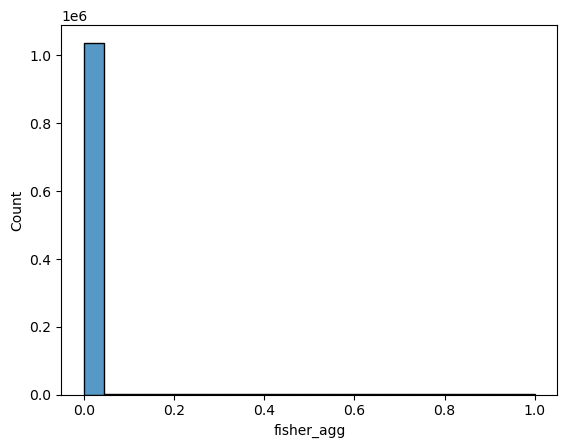

In [789]:
sns.histplot(wza_df['fisher_agg'])

In [779]:
large_w = wza_df[wza_df['SNPs'] > 100]

Text(0.5, 0, 'Weighted_z_score')

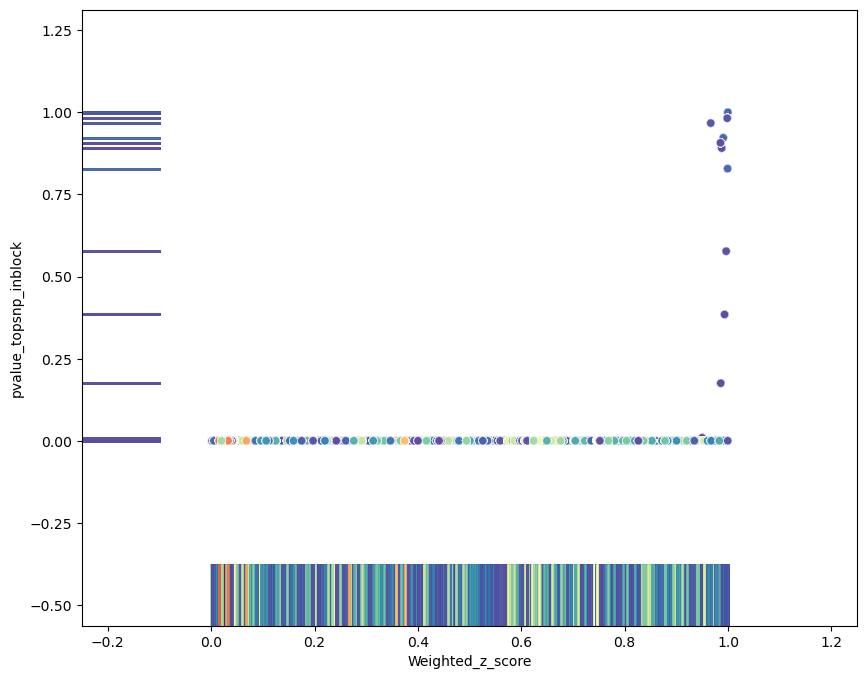

In [790]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data = large_w, x = 'Z_pVal_old_poly', y = 'K_tau_p_agg', hue = 'SNPs', alpha = 0.5, palette='Spectral_r', legend=False)#.set_yscale("log").set_xscale("log")
sns.rugplot(data=large_w, x="Z_pVal_old_poly", y="K_tau_p_agg", height=.1, alpha=0.2,hue = 'SNPs',palette='Spectral_r', legend=False)#.set_yscale("log").set_xscale("log")
plt.ylabel('pvalue_topsnp_inblock')
plt.xlabel('Weighted_z_score')

Text(0.5, 0, 'Weighted_z_score')

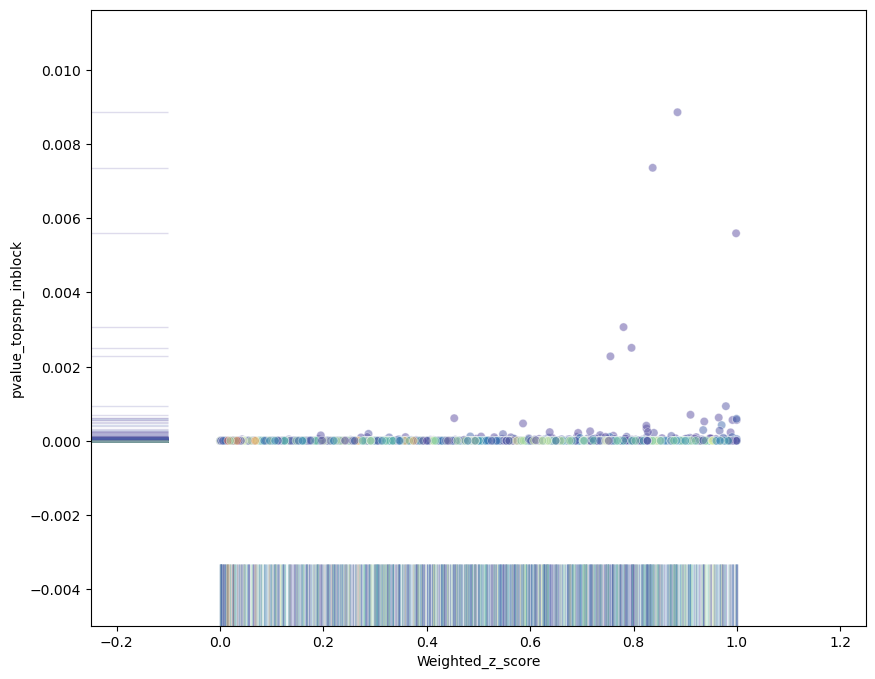

In [762]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data = large_w, x = 'Z_pVal_old_poly', y = 'K_tau_p', hue = 'SNPs', alpha = 0.5, palette='Spectral_r', legend=False)#.set_yscale("log").set_xscale("log")
sns.rugplot(data=large_w, x="Z_pVal_old_poly", y="K_tau_p", height=.1, alpha=0.2,hue = 'SNPs',palette='Spectral_r', legend=False)#.set_yscale("log").set_xscale("log")
plt.ylabel('pvalue_topsnp_inblock')
plt.xlabel('Weighted_z_score')

<Axes: xlabel='Z_no_spline', ylabel='K_tau_p'>

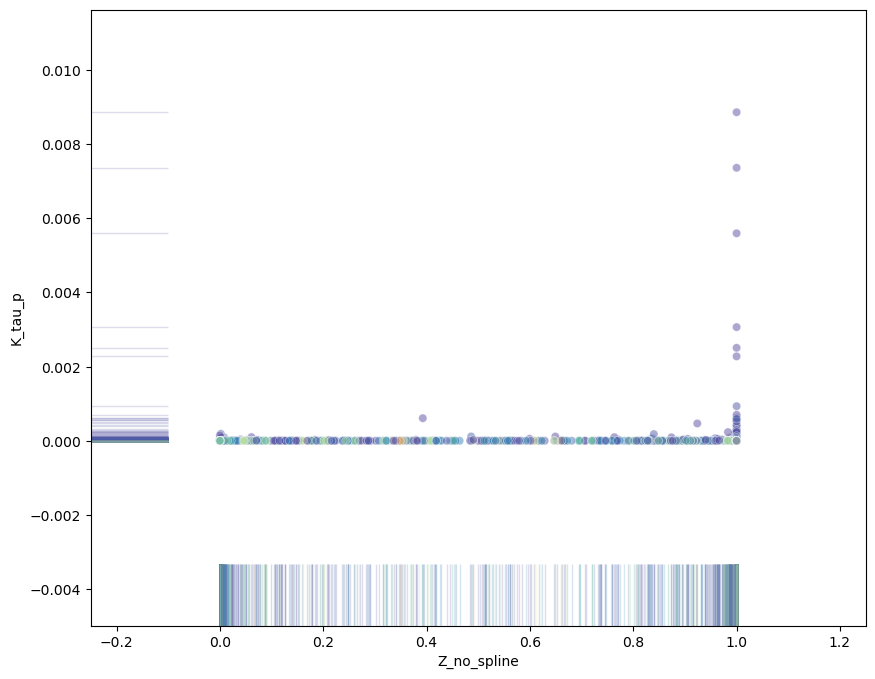

In [760]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data = large_w, x = 'Z_no_spline', y = 'K_tau_p', hue = 'SNPs', alpha = 0.5, palette='Spectral_r', legend=False)#.set_yscale("log").set_xscale("log")
sns.rugplot(data=large_w, x="Z_no_spline", y="K_tau_p", height=.1, alpha=0.2,hue = 'SNPs',palette='Spectral_r', legend=False)#.set_yscale("log").set_xscale("log")

Text(0.5, 0, 'Weighted_z_score')

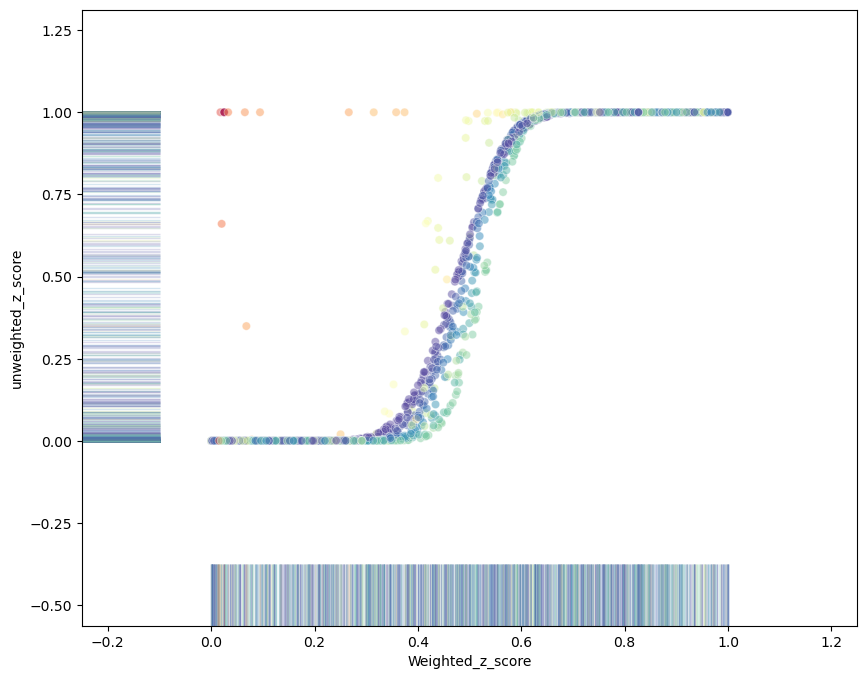

In [763]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data = large_w, x = 'Z_pVal_old_poly', y = 'Z_no_spline', hue = 'SNPs', alpha = 0.5, palette='Spectral_r', legend=False)#.set_yscale("log").set_xscale("log")
sns.rugplot(data=large_w, x="Z_pVal_old_poly", y="Z_no_spline", height=.1, alpha=0.2,hue = 'SNPs',palette='Spectral_r', legend=False)#.set_yscale("log").set_xscale("log")
plt.ylabel('unweighted_z_score')
plt.xlabel('Weighted_z_score')

Text(0.5, 0, 'Weighted_z_score')

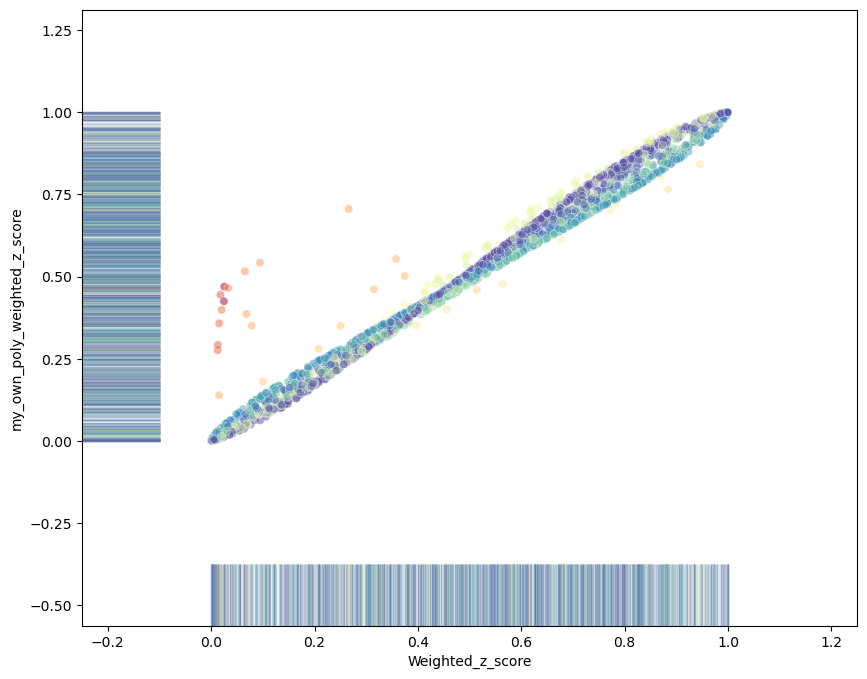

In [764]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data = large_w, x = 'Z_pVal_old_poly', y = 'Z_pVal_newpoly', hue = 'SNPs', alpha = 0.5, palette='Spectral_r', legend=False)#.set_yscale("log").set_xscale("log")
sns.rugplot(data=large_w, x="Z_pVal_old_poly", y="Z_pVal_newpoly", height=.1, alpha=0.2,hue = 'SNPs',palette='Spectral_r', legend=False)#.set_yscale("log").set_xscale("log")
plt.ylabel('my_own_poly_weighted_z_score')
plt.xlabel('Weighted_z_score')

<Axes: xlabel='Z_pVal_old_poly', ylabel='Z_pVal_old_poly'>

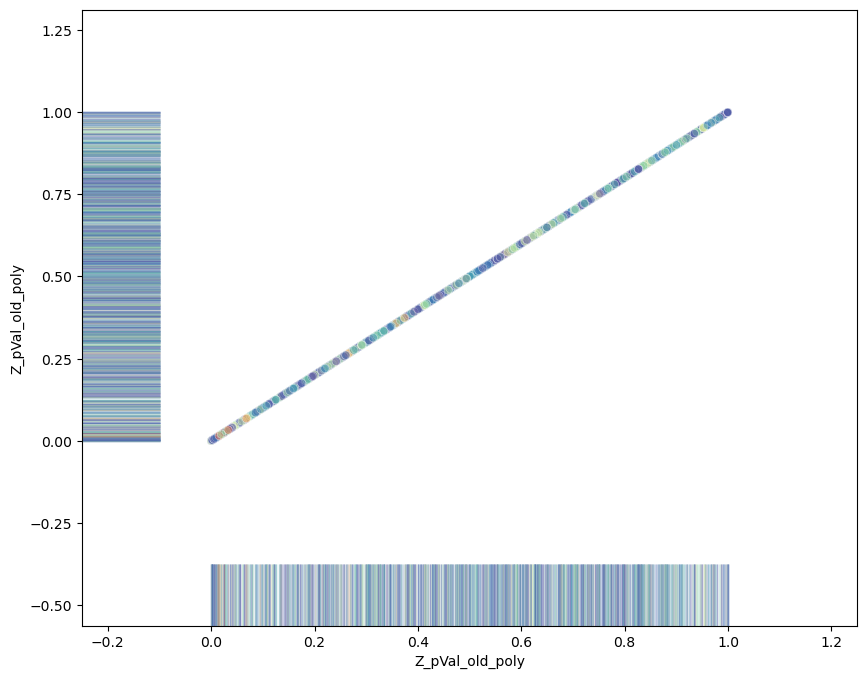

In [735]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data = large_w, x = 'Z_pVal_old_poly', y = 'Z_pVal_old_poly', hue = 'SNPs', alpha = 0.5, palette='Spectral_r', legend=False)#.set_yscale("log").set_xscale("log")
sns.rugplot(data=large_w, x="Z_pVal_old_poly", y="Z_pVal_old_poly", height=.1, alpha=0.2,hue = 'SNPs',palette='Spectral_r', legend=False)#.set_yscale("log").set_xscale("log")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


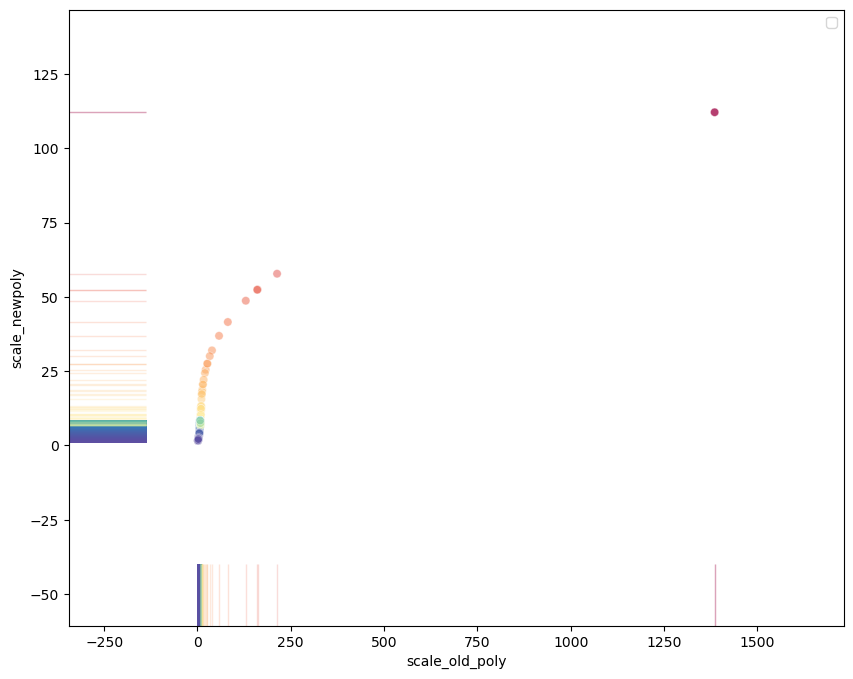

In [736]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 8))

# Scatter plot
sns.scatterplot(data=wza_df, x='scale_old_poly', y='scale_newpoly', hue='SNPs', alpha=0.5, palette='Spectral_r', legend=False)

# Rug plot
sns.rugplot(data=wza_df, x="scale_old_poly", y="scale_newpoly", height=.1, alpha=0.2, hue='SNPs', palette='Spectral_r', legend=False)

plt.legend()
plt.show()

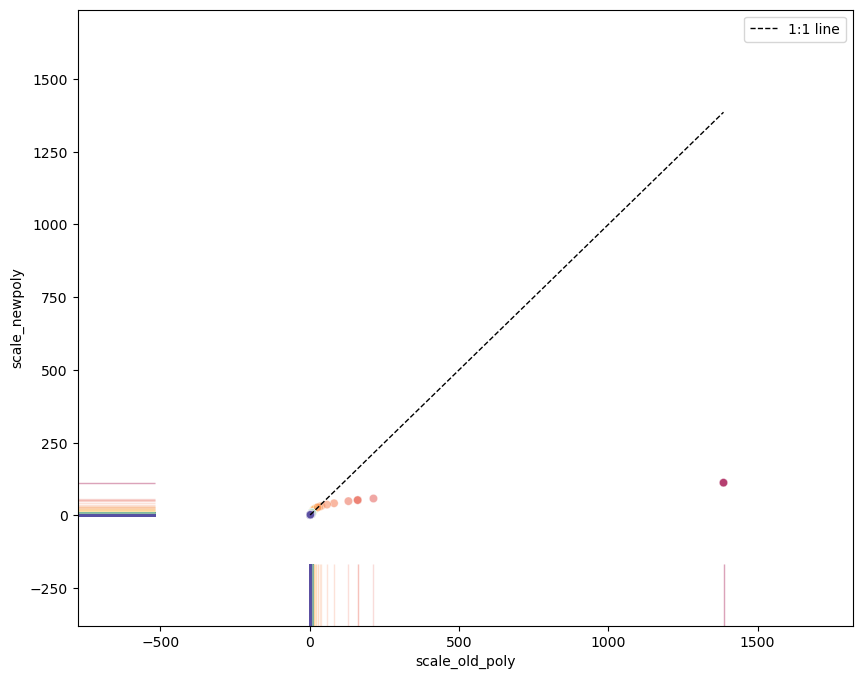

In [737]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 8))

# Scatter plot
sns.scatterplot(data=wza_df, x='scale_old_poly', y='scale_newpoly', hue='SNPs', alpha=0.5, palette='Spectral_r', legend=False)

# Rug plot
sns.rugplot(data=wza_df, x="scale_old_poly", y="scale_newpoly", height=.1, alpha=0.2, hue='SNPs', palette='Spectral_r', legend=False)

# Add a 1:1 comparison line
min_val = min(wza_df['scale_old_poly'].min(), wza_df['scale_newpoly'].min())
max_val = max(wza_df['scale_old_poly'].max(), wza_df['scale_newpoly'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', linewidth=1, label="1:1 line")

# Show plot
plt.legend()
plt.show()


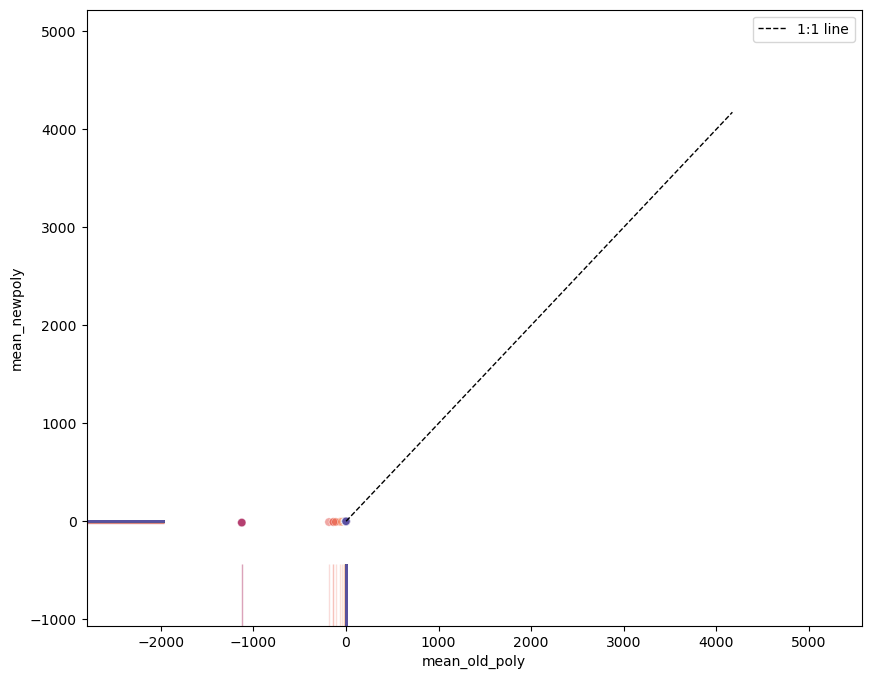

In [647]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 8))

# Scatter plot
sns.scatterplot(data=wza_df, x='mean_old_poly', y='mean_newpoly', hue='SNPs', alpha=0.5, palette='Spectral_r', legend=False)

# Rug plot
sns.rugplot(data=wza_df, x="mean_old_poly", y="mean_newpoly", height=.1, alpha=0.2, hue='SNPs', palette='Spectral_r', legend=False)

# Add a 1:1 comparison line
min_val = min(wza_df['scale_old_poly'].min(), wza_df['scale_newpoly'].min())
max_val = max(wza_df['scale_old_poly'].max(), wza_df['scale_newpoly'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', linewidth=1, label="1:1 line")

# Show plot
plt.legend()
plt.show()

In [738]:
wza_df

,Unnamed: 0,gene,SNPs,hits,Z,top_candidate_p,scale_old_poly,mean_old_poly,Z_pVal_old_poly,scale_newpoly,mean_newpoly,Z_pVal_newpoly,Z_no_spline
0,0,1_0,198,0,-5.382798,1.0,6.117179,-0.265433,0.798579,5.862682,-0.146079,0.814133,1.000000
1,1,1_1,3,0,-1.266673,1.0,1.375660,-0.076370,0.806552,1.598254,-0.120764,0.763306,0.897364
2,2,1_10,22,0,-1.211412,1.0,2.328407,-0.165085,0.673419,2.129878,-0.130758,0.694055,0.887131
3,3,1_100,53,0,3.029274,1.0,3.567251,-0.258689,0.178341,2.940168,-0.143120,0.140297,0.001226
4,4,1_1000,9,0,2.030071,1.0,1.694126,-0.107369,0.103533,1.769058,-0.124125,0.111668,0.021175
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16651,16651,5_995,39,0,-4.429697,1.0,3.052121,-0.223305,0.915927,2.582873,-0.138125,0.951698,0.999995
16652,16652,5_996,3,0,-0.225149,1.0,1.375660,-0.076370,0.543062,1.598254,-0.120764,0.526037,0.589068
16653,16653,5_997,27,0,-2.670487,1.0,2.553171,-0.184112,0.834932,2.265314,-0.133076,0.868668,0.996213
16654,16654,5_998,7,0,-2.067785,1.0,1.589839,-0.097358,0.892399,1.712425,-0.123026,0.871954,0.980670


In [739]:
new = wza_df[wza_df['Z_pVal_newpoly'] < 0.05/len(wza_df)]
for i in new['gene']:
    print(dict_blocks[i][0].split('_')[0] + ':' + dict_blocks[i][0].split('_')[1]  + '-' + dict_blocks[i][-1].split('_')[1])

1:9396749-9398971
2:11533904-11534263
2:605830-606247
2:8283111-8283835
3:18471464-18475875
3:19814798-19815556
4:7255726-7269426
5:19276567-19387194


In [740]:
new['gene'].values

array(['1_1391', '2_1265', '2_199', '2_897', '3_2730', '3_3044', '4_801',
       '5_2227'], dtype=object)

In [741]:
new

,Unnamed: 0,gene,SNPs,hits,Z,top_candidate_p,scale_old_poly,mean_old_poly,Z_pVal_old_poly,scale_newpoly,mean_newpoly,Z_pVal_newpoly,Z_no_spline
431,431,1_1391,27,19,11.351576,2.056867e-32,2.553171,-0.184112,3.118647e-06,2.265314,-0.133076,1.991332e-07,0.000000e+00
5407,5407,2_1265,16,5,9.028052,3.984317e-07,2.044853,-0.139984,3.671941e-06,1.964912,-0.127806,1.583525e-06,0.000000e+00
6199,6199,2_199,10,9,9.224959,9.910000e-18,1.745580,-0.112257,4.420582e-08,1.797262,-0.124667,9.849893e-08,0.000000e+00
7135,7135,2_897,30,18,11.773300,7.715812e-29,2.683162,-0.194743,4.089873e-06,2.345691,-0.134406,1.923092e-07,0.000000e+00
9133,9133,3_2730,53,30,15.113784,4.984762e-46,3.567251,-0.258689,8.187385e-06,2.940168,-0.143120,1.056411e-07,0.000000e+00
9478,9478,3_3044,10,8,8.286335,4.420360e-15,1.745580,-0.112257,7.495833e-07,1.797262,-0.124667,1.435100e-06,1.110223e-16
13384,13384,4_801,225,146,31.615317,5.445274e-231,6.270198,-0.234372,1.891799e-07,6.262747,-0.138552,1.986171e-07,0.000000e+00
14942,14942,5_2227,1088,151,40.443817,6.143664e-118,7.967378,-0.589277,1.301475e-07,6.802195,-0.169717,1.181543e-09,0.000000e+00


In [742]:
new = wza_df[wza_df['Z_pVal_old_poly'] < 0.05/len(wza_df)]
for i in new['gene']:
    print(dict_blocks[i][0].split('_')[0] + ':' + dict_blocks[i][0].split('_')[1]  + '-' + dict_blocks[i][-1].split('_')[1])

2:605830-606247
3:19814798-19815556
4:7255726-7269426
5:19276567-19387194


In [743]:
new

,Unnamed: 0,gene,SNPs,hits,Z,top_candidate_p,scale_old_poly,mean_old_poly,Z_pVal_old_poly,scale_newpoly,mean_newpoly,Z_pVal_newpoly,Z_no_spline
6199,6199,2_199,10,9,9.224959,9.910000e-18,1.745580,-0.112257,4.420582e-08,1.797262,-0.124667,9.849893e-08,0.000000e+00
9478,9478,3_3044,10,8,8.286335,4.420360e-15,1.745580,-0.112257,7.495833e-07,1.797262,-0.124667,1.435100e-06,1.110223e-16
13384,13384,4_801,225,146,31.615317,5.445274e-231,6.270198,-0.234372,1.891799e-07,6.262747,-0.138552,1.986171e-07,0.000000e+00
14942,14942,5_2227,1088,151,40.443817,6.143664e-118,7.967378,-0.589277,1.301475e-07,6.802195,-0.169717,1.181543e-09,0.000000e+00


In [655]:
wza_df[wza_df['Z_pVal'].isna()]

KeyError: 'Z_pVal'

In [ ]:
wza_df['scale'] = sd_predictions

wza_df['mean'] = mean_predictions

<Axes: xlabel='SNPs', ylabel='mean'>

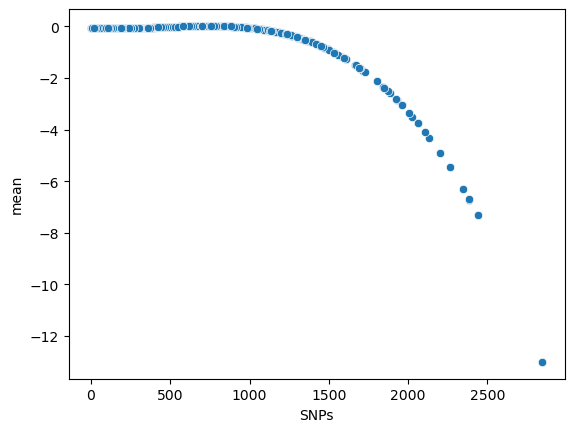

In [497]:
sns.scatterplot(data = wza_df, x = 'SNPs', y = 'mean')

In [744]:
sns.scatterplot(data = wza_df, x = 'SNPs', y = 'scale', alpha=0.2)#.set_yscale("log")
#sns.rugplot(data=wza_df, x="SNPs", y="scale", height=.1, alpha=0.2)

ValueError: Could not interpret value `scale` for parameter `y`

In [499]:
'1_4899', '2_1265', '2_199',

('1_4899', '2_1265', '2_199')

<Axes: xlabel='SNPs', ylabel='scale'>

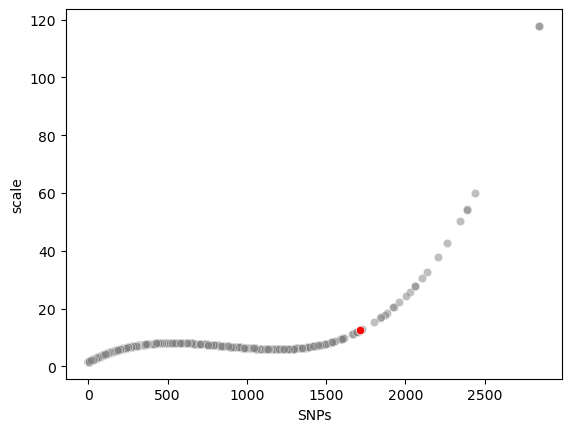

In [500]:
# Create a new column 'highlight' to identify rows where the gene is one of the specified ones
highlight_genes = [ '2_970']
wza_df['highlight'] = np.where(wza_df['gene'].isin(highlight_genes), 'red', 'grey')

# Plot the non-highlighted (grey) points first
sns.scatterplot(
    data=wza_df[wza_df['highlight'] == 'grey'], 
    x='SNPs', 
    y='scale', 
    color='grey',  # Color for non-highlighted points
    alpha=0.5  # Transparency
)#.set_yscale("log")

# Now plot the highlighted (red) points on top
sns.scatterplot(
    data=wza_df[wza_df['highlight'] == 'red'], 
    x='SNPs', 
    y='scale', 
    color='red',  # Color for highlighted points
    alpha=1,  # Full opacity for better visibility
    zorder=3  # Ensure these points are drawn on top
)

<Axes: xlabel='SNPs', ylabel='scale'>

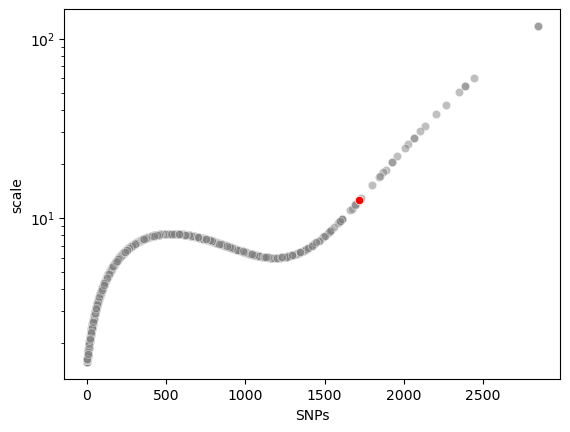

In [501]:
# Create a new column 'highlight' to identify rows where the gene is one of the specified ones
highlight_genes = [ '2_970']
wza_df['highlight'] = np.where(wza_df['gene'].isin(highlight_genes), 'red', 'grey')

# Plot the non-highlighted (grey) points first
sns.scatterplot(
    data=wza_df[wza_df['highlight'] == 'grey'], 
    x='SNPs', 
    y='scale', 
    color='grey',  # Color for non-highlighted points
    alpha=0.5  # Transparency
).set_yscale("log")

# Now plot the highlighted (red) points on top
sns.scatterplot(
    data=wza_df[wza_df['highlight'] == 'red'], 
    x='SNPs', 
    y='scale', 
    color='red',  # Color for highlighted points
    alpha=1,  # Full opacity for better visibility
    zorder=3  # Ensure these points are drawn on top
)

In [31]:
wza_df[wza_df['scale']>=0]['SNPs'].max()

1870

In [32]:
wza_df['Z_pVal'] = wza_p_values

<Axes: xlabel='scale', ylabel='Z_pVal'>

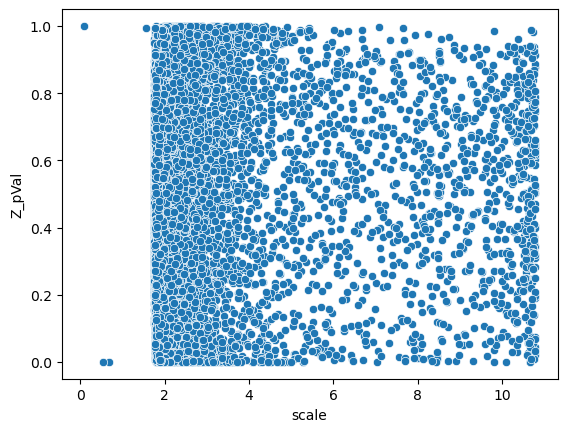

In [33]:
sns.scatterplot(data = wza_df, x = 'scale', y = 'Z_pVal')

In [35]:
wza_df

,Unnamed: 0,gene,SNPs,hits,Z,top_candidate_p,scale,mean,Z_pVal
0,0,1_0,198,0,-4.007570,1.0,5.293833,-0.019397,0.774384
1,1,1_1,3,0,1.565350,1.0,1.799345,-0.282861,0.152173
2,2,1_10,22,0,2.396965,1.0,2.177501,-0.256704,0.111484
3,3,1_100,53,0,0.687459,1.0,2.777034,-0.214252,0.372703
4,4,1_1000,9,0,1.943490,1.0,1.919642,-0.274590,0.123950
...,...,...,...,...,...,...,...,...,...
16651,16651,5_995,39,0,-1.339041,1.0,2.508958,-0.233389,0.670278
16652,16652,5_996,3,0,1.780138,1.0,1.799345,-0.282861,0.125788
16653,16653,5_997,27,0,-0.174069,1.0,2.275665,-0.249838,0.486720
16654,16654,5_998,7,0,-0.181786,1.0,1.879633,-0.277346,0.479727


In [73]:
len(wza_df[wza_df['scale']<0])

22

In [183]:
wza_df

,Unnamed: 0,gene,SNPs,hits,Z,top_candidate_p,Z_pVal,scale,mean,highlight
0,0,1_0,198,0,-4.007570,1.0,0.733817,6.387280,-0.019363,grey
1,1,1_1,3,0,1.565350,1.0,0.085124,1.347361,-0.282430,grey
2,2,1_10,22,0,2.396965,1.0,0.143519,2.492187,-0.256317,grey
3,3,1_100,53,0,0.687459,1.0,0.408834,3.909823,-0.213935,grey
4,4,1_1000,9,0,1.943490,1.0,0.100527,1.734509,-0.274172,grey
...,...,...,...,...,...,...,...,...,...,...
16651,16651,5_995,39,0,-1.339041,1.0,0.630043,3.331648,-0.233041,grey
16652,16652,5_996,3,0,1.780138,1.0,0.062907,1.347361,-0.282430,grey
16653,16653,5_997,27,0,-0.174069,1.0,0.489088,2.755974,-0.249462,grey
16654,16654,5_998,7,0,-0.181786,1.0,0.476413,1.608199,-0.276924,grey


In [631]:
#wza_df[wza_df['sd']<0].sort_values('sd')

In [632]:
#pd.Series(sdev)[pd.Series(sdev) < 0]

In [633]:
rolled_mean_SNP_number

9622        1.00
13779       1.00
3171        1.00
13781       1.00
7924        1.00
          ...   
4572     1561.46
10063    1565.08
6831     1568.62
6795     1572.00
1246     1575.14
Name: SNPs, Length: 16617, dtype: float64

In [108]:
loc = mean_predictions[i]
loc

-0.0479122787548165

In [122]:
i

16655

In [123]:
wza_df["SNPs"][i]

20

In [161]:
scale = sd_predictions[i]
scale

2.08857969097792

In [174]:
scale = 1

In [175]:
z = wza_df["Z"][i]
z

1.2193371615648432

In [176]:
p = 1 - norm.cdf(z, loc = loc, scale =scale)

In [177]:
p

0.10253305632753396

In [89]:
gotneg = []
for i in range(wza_df.shape[0]):
    loc = mean_predictions[i]
    scale = sd_predictions[i]
    p = 1 - norm.cdf(wza_df["Z"][i], loc = loc, scale =scale)
    if np.isnan(p):
        print(loc, scale, wza_df["Z"][i], rolled_mean_SNP_number[i])

In [541]:
gotneg

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

In [49]:
wza_results_lfmm_bio1_pol7 = pd.read_csv('wza_results_lfmm_bio1_nocorrsnps.csv')

In [662]:
wza_results_lfmm_bio1_pol7 = wza_df.copy()

In [663]:
wza_results_lfmm_bio1_pol7

,Unnamed: 0,gene,SNPs,hits,Z,top_candidate_p,scale_old_poly,mean_old_poly,Z_pVal_old_poly,scale_newpoly,mean_newpoly,Z_pVal_newpoly,Z_no_spline
0,0,1_0,198,0,-6.628373,1.0,5.953956,-0.137973,0.862165,5.886561,-0.070535,0.867368,1.000000e+00
1,1,1_1,3,0,2.004490,1.0,1.346746,-0.031463,0.065298,1.626300,-0.042741,0.104046,2.250879e-02
2,2,1_10,22,0,-0.083653,1.0,2.433552,-0.054904,0.504713,2.162900,-0.049252,0.506345,5.333336e-01
3,3,1_100,53,0,-0.937833,1.0,3.767794,-0.083763,0.589662,2.978625,-0.057889,0.616163,8.258349e-01
4,4,1_1000,9,0,0.012213,1.0,1.714946,-0.039423,0.487990,1.798814,-0.044901,0.487335,4.951278e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16651,16651,5_995,39,0,-0.621054,1.0,3.225700,-0.071975,0.567582,2.619280,-0.054285,0.585656,7.327180e-01
16652,16652,5_996,3,0,1.622175,1.0,1.346746,-0.031463,0.109747,1.626300,-0.042741,0.152978,5.238292e-02
16653,16653,5_997,27,0,4.765707,1.0,2.682997,-0.060272,0.036031,2.299435,-0.050809,0.018101,9.409640e-07
16654,16654,5_998,7,0,-1.304242,1.0,1.594886,-0.036830,0.786598,1.741625,-0.044192,0.765311,9.039245e-01


In [664]:
wza_results_lfmm_bio1_pol7[wza_results_lfmm_bio1_pol7['Z_no_spline'].isna()]

,Unnamed: 0,gene,SNPs,hits,Z,top_candidate_p,scale_old_poly,mean_old_poly,Z_pVal_old_poly,scale_newpoly,mean_newpoly,Z_pVal_newpoly,Z_no_spline


In [665]:
from statsmodels.stats.multitest import multipletests
wza_results_lfmm_bio1_pol7['BH_corrected_p'] = multipletests(wza_results_lfmm_bio1_pol7['Z_no_spline'], method='fdr_bh')[1]

In [666]:
wza_results_lfmm_bio1_pol7

,Unnamed: 0,gene,SNPs,hits,Z,top_candidate_p,scale_old_poly,mean_old_poly,Z_pVal_old_poly,scale_newpoly,mean_newpoly,Z_pVal_newpoly,Z_no_spline,BH_corrected_p
0,0,1_0,198,0,-6.628373,1.0,5.953956,-0.137973,0.862165,5.886561,-0.070535,0.867368,1.000000e+00,1.000000
1,1,1_1,3,0,2.004490,1.0,1.346746,-0.031463,0.065298,1.626300,-0.042741,0.104046,2.250879e-02,0.154092
2,2,1_10,22,0,-0.083653,1.0,2.433552,-0.054904,0.504713,2.162900,-0.049252,0.506345,5.333336e-01,1.000000
3,3,1_100,53,0,-0.937833,1.0,3.767794,-0.083763,0.589662,2.978625,-0.057889,0.616163,8.258349e-01,1.000000
4,4,1_1000,9,0,0.012213,1.0,1.714946,-0.039423,0.487990,1.798814,-0.044901,0.487335,4.951278e-01,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16651,16651,5_995,39,0,-0.621054,1.0,3.225700,-0.071975,0.567582,2.619280,-0.054285,0.585656,7.327180e-01,1.000000
16652,16652,5_996,3,0,1.622175,1.0,1.346746,-0.031463,0.109747,1.626300,-0.042741,0.152978,5.238292e-02,0.282113
16653,16653,5_997,27,0,4.765707,1.0,2.682997,-0.060272,0.036031,2.299435,-0.050809,0.018101,9.409640e-07,0.000024
16654,16654,5_998,7,0,-1.304242,1.0,1.594886,-0.036830,0.786598,1.741625,-0.044192,0.765311,9.039245e-01,1.000000


In [667]:
threshold_value = 0.05 / len(wza_results_lfmm_bio1_pol7)

In [668]:
#wza_lfmm[wza_lfmm['Z_pVal']< threshold_value].to_csv('wza_lfmm_significant_blocks.csv',index=None)

/tmp/ipykernel_259589/3704011610.py:1: RuntimeWarning: divide by zero encountered in log10
  observed_quantiles = -np.log10(np.sort(wza_results_lfmm_bio1_pol7['Z_no_spline'].values))


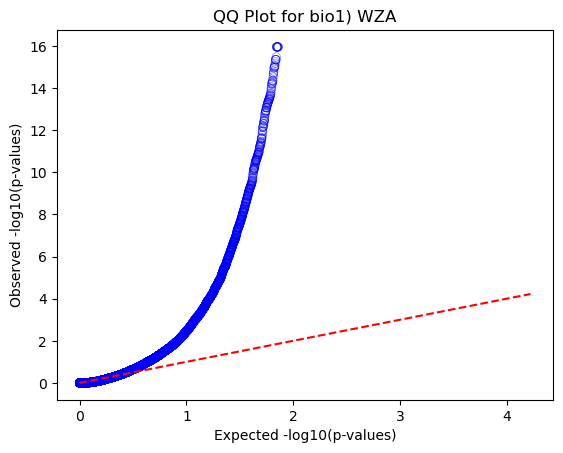

In [669]:
observed_quantiles = -np.log10(np.sort(wza_results_lfmm_bio1_pol7['Z_no_spline'].values))

# Expected quantiles from the uniform distribution
expected_quantiles = -np.log10(np.linspace(1 / len(wza_results_lfmm_bio1_pol7), 1, len(wza_results_lfmm_bio1_pol7)))

# QQ plot
sns.scatterplot(x = expected_quantiles, y = observed_quantiles, edgecolor='b', facecolor='none', alpha=0.5)
plt.plot([min(expected_quantiles), max(expected_quantiles)], [min(expected_quantiles), max(expected_quantiles)], 'r--')

plt.xlabel("Expected -log10(p-values)")
plt.ylabel("Observed -log10(p-values)")
plt.title(f'QQ Plot for {biovar}) WZA')

plt.show()

In [342]:
old = pd.read_csv('wza_results_lfmm_bio1.csv')

In [343]:
old = old[old['Z_pVal'] < threshold_value]

In [672]:
new = wza_results_lfmm_bio1_pol7[wza_results_lfmm_bio1_pol7['Z_no_spline'] < threshold_value]

In [673]:
new

,Unnamed: 0,gene,SNPs,hits,Z,top_candidate_p,scale_old_poly,mean_old_poly,Z_pVal_old_poly,scale_newpoly,mean_newpoly,Z_pVal_newpoly,Z_no_spline,BH_corrected_p
57,57,1_1049,31,0,5.780258,1.000000e+00,2.872445,-0.064351,0.020940,2.407275,-0.052008,0.007701,3.729314e-09,1.324423e-07
81,81,1_1071,196,1,9.358674,8.605244e-01,5.946584,-0.137777,0.055137,5.855855,-0.070622,0.053673,0.000000e+00,0.000000e+00
166,166,1_1149,322,0,8.760475,1.000000e+00,6.198671,-0.121819,0.075938,7.341429,-0.055017,0.114917,0.000000e+00,0.000000e+00
172,172,1_1154,886,13,6.776339,1.131833e-01,7.182119,0.236151,0.181248,6.938324,0.000694,0.164395,6.162959e-12,3.010271e-10
179,179,1_1160,30,5,8.597129,1.156757e-05,2.825906,-0.063349,0.001090,2.380430,-0.051712,0.000140,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16613,16613,5_959,127,0,9.311722,1.000000e+00,5.435094,-0.122925,0.041293,4.641013,-0.069509,0.021620,0.000000e+00,0.000000e+00
16626,16626,5_972,51,0,9.455147,1.000000e+00,3.695927,-0.082191,0.004933,2.928191,-0.057404,0.000580,0.000000e+00,0.000000e+00
16627,16627,5_973,882,121,8.260870,2.821113e-94,7.191886,0.240960,0.132397,6.958085,0.001907,0.117622,1.110223e-16,7.737186e-15
16629,16629,5_975,112,0,6.100934,1.000000e+00,5.222892,-0.117378,0.116908,4.335256,-0.068099,0.077369,5.272519e-10,2.085964e-08


In [346]:
old

,gene,SNPs,hits,Z,top_candidate_p,Z_pVal
350,1_1318,44,22,13.132881,1.703152e-32,5.361920e-08
654,1_1594,30,15,12.340603,1.346841e-22,1.942342e-08
2046,1_2867,64,12,12.798694,2.029109e-12,2.191944e-06
3850,1_4505,96,9,17.562307,5.923819e-07,4.216780e-08
4126,1_4758,40,2,11.020971,6.073662e-02,2.316135e-06
4227,1_485,36,3,12.925697,5.580758e-03,1.722963e-08
4789,1_702,1699,267,12.236921,1.282245e-221,8.324132e-10
5244,2_1116,26,22,10.800096,1.438617e-40,3.594995e-07
5407,2_1265,16,15,11.151806,1.585000e-29,1.569795e-08
7059,2_827,141,82,22.186910,1.602818e-124,8.449797e-09


In [347]:
old.merge(new, on ='gene', how='outer')

,gene,SNPs_x,hits_x,Z_x,top_candidate_p_x,Z_pVal_x,Unnamed: 0,SNPs_y,hits_y,Z_y,top_candidate_p_y,Z_pVal_y,scale,mean,highlight,BH_corrected_p
0,1_1318,44.0,22.0,13.132881,1.703152e-32,5.361920e-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1_1594,30.0,15.0,12.340603,1.346841e-22,1.942342e-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1_2867,64.0,12.0,12.798694,2.029109e-12,2.191944e-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1_4505,96.0,9.0,17.562307,5.923819e-07,4.216780e-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1_4758,40.0,2.0,11.020971,6.073662e-02,2.316135e-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,5_682,NaN,NaN,NaN,NaN,NaN,16313.0,146.0,8.0,13.979979,1.241200e-04,3.722166e-07,2.823233,0.006676,grey,0.000136
74,5_70,NaN,NaN,NaN,NaN,NaN,16333.0,410.0,51.0,19.708121,1.306228e-38,2.411018e-07,3.911775,0.019131,grey,0.000093
75,5_733,NaN,NaN,NaN,NaN,NaN,16370.0,790.0,48.0,34.215027,1.557333e-22,2.434097e-08,6.255057,0.087072,grey,0.000013
76,5_771,NaN,NaN,NaN,NaN,NaN,16411.0,199.0,0.0,15.827154,1.000000e+00,7.686337e-08,3.014251,0.008247,grey,0.000036


In [198]:
1_4899 

2_199

2199

In [199]:
5_2922

52922

In [200]:
import pickle
dict_blocks = '../key_files/blocks_snpsid_dict.pkl'

with open(dict_blocks, 'rb') as file:
    dict_blocks = pickle.load(file)

reverse_mapping = {item: key for key, values in dict_blocks.items() for item in values}

In [201]:
dict_blocks['1_1113'][-1] #5:24100585-24286474

'5_24286474'

In [ ]:
dict_blocks['4_2115'][-1] 

In [210]:
dict_blocks['4_2115'][-1].split('_')

['4', '10524180']

In [674]:
new = wza_results_lfmm_bio1_pol7[wza_results_lfmm_bio1_pol7['Z_no_spline'] < threshold_value]
for i in new['gene']:
    print(dict_blocks[i][0].split('_')[0] + ':' + dict_blocks[i][0].split('_')[1]  + '-' + dict_blocks[i][-1].split('_')[1])

1:7894273-7895419
1:8077629-8099395
1:8430397-8471156
1:8485009-8539883
1:8542934-8544581
1:8544754-8545576
1:8586029-8594415
1:8657074-8679044
1:8921804-8926982
1:8941992-8945860
1:8958699-8963153
1:8977820-8978498
1:9089683-9177782
1:9200328-9218778
1:9219501-9221073
1:9221895-9223962
1:9280020-9285293
1:9379045-9383113
1:9483740-9486540
1:9498191-9609325
1:10164764-10243326
1:10300317-10371242
1:10720522-10726379
1:10872248-10892617
1:10895628-10898797
1:10899600-10900996
1:10901940-10903772
1:10903783-10903991
1:11175476-11180843
1:11181876-11222882
1:11327552-11328772
1:11374334-11380657
1:11462621-11463425
1:1307600-1308948
1:1461066-1544403
1:11694130-11697617
1:11829116-11904953
1:11929826-11935902
1:12073876-12078905
1:12286773-12344490
1:12376230-12390343
1:12583284-12590403
1:12975552-12982229
1:13078838-13142646
1:13148528-13158913
1:13164054-13210075
1:15651181-15935502
1:16136724-16137741
1:16139622-16141778
1:16150921-16154770
1:1715672-1717182
1:16228341-16342195
1:1634

In [202]:
new

,Unnamed: 0,gene,SNPs,hits,Z,top_candidate_p,Z_pVal,scale,mean,highlight,BH_corrected_p
128,128,1_1113,8,8,8.622997,1.000000e-16,5.101309e-08,1.671692,-0.275548,grey,0.000850
11812,11812,4_2115,11,9,9.039108,5.401450e-17,2.712044e-07,1.858141,-0.271422,grey,0.002151
16190,16190,5_571,46,28,17.715829,2.367289e-44,3.937851e-07,3.632599,-0.223481,grey,0.002151
16397,16397,5_758,8,8,7.891025,1.000000e-16,5.165814e-07,1.671692,-0.275548,grey,0.002151


In [678]:
blocks_di

NameError: name 'blocks_di' is not defined

In [66]:
set(wza_lfmm.loc[wza_lfmm['Z_pVal'] == 0]['gene']).intersection(set(nan_blocks_0_min))

NameError: name 'wza_lfmm' is not defined

In [67]:
wza_lfmm.loc[wza_lfmm['Z_pVal'] == 0]

NameError: name 'wza_lfmm' is not defined

<Axes: xlabel='Z_pVal', ylabel='Count'>

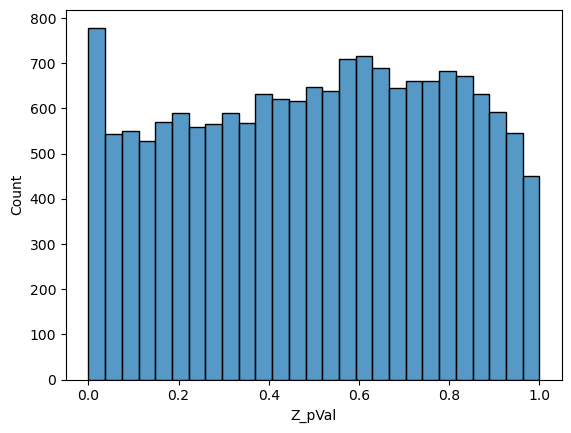

In [203]:
sns.histplot(wza_results_lfmm_bio1_pol7['Z_pVal'])

In [675]:
wza_results_lfmm_bio1_pol7['chrom'] = wza_results_lfmm_bio1_pol7['gene'].str.split('_').str[0].astype(int)
wza_results_lfmm_bio1_pol7['pos'] = wza_results_lfmm_bio1_pol7['gene'].str.split('_').str[1].astype(int)

In [676]:
wza_results_lfmm_bio1_pol7[wza_results_lfmm_bio1_pol7['BH_corrected_p'] < 0.05]

,Unnamed: 0,gene,SNPs,hits,Z,top_candidate_p,scale_old_poly,mean_old_poly,Z_pVal_old_poly,scale_newpoly,mean_newpoly,Z_pVal_newpoly,Z_no_spline,BH_corrected_p,chrom,pos
36,36,1_103,3,0,2.747270,1.000000e+00,1.346746,-0.031463,0.019542,1.626300,-0.042741,0.043121,3.004678e-03,3.104148e-02,1,103
44,44,1_1037,168,0,2.746999,1.000000e+00,5.809053,-0.133686,0.309984,5.399842,-0.071170,0.300871,3.007167e-03,3.104148e-02,1,1037
48,48,1_1040,93,0,2.721901,1.000000e+00,4.875755,-0.108848,0.280763,3.925578,-0.065649,0.238821,3.245382e-03,3.306122e-02,1,1040
57,57,1_1049,31,0,5.780258,1.000000e+00,2.872445,-0.064351,0.020940,2.407275,-0.052008,0.007701,3.729314e-09,1.324423e-07,1,1049
75,75,1_1066,373,4,3.329145,5.128518e-01,6.326611,-0.096073,0.294116,7.707730,-0.044427,0.330807,4.355651e-04,5.956398e-03,1,1066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16626,16626,5_972,51,0,9.455147,1.000000e+00,3.695927,-0.082191,0.004933,2.928191,-0.057404,0.000580,0.000000e+00,0.000000e+00,5,972
16627,16627,5_973,882,121,8.260870,2.821113e-94,7.191886,0.240960,0.132397,6.958085,0.001907,0.117622,1.110223e-16,7.737186e-15,5,973
16629,16629,5_975,112,0,6.100934,1.000000e+00,5.222892,-0.117378,0.116908,4.335256,-0.068099,0.077369,5.272519e-10,2.085964e-08,5,975
16643,16643,5_988,3,0,3.066040,1.000000e+00,1.346746,-0.031463,0.010724,1.626300,-0.042741,0.027966,1.084570e-03,1.291251e-02,5,988


In [350]:
## bh controling 

/home/tbellagio/miniforge3/envs/pipeline_snakemake/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_259589/3799206676.py:47: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


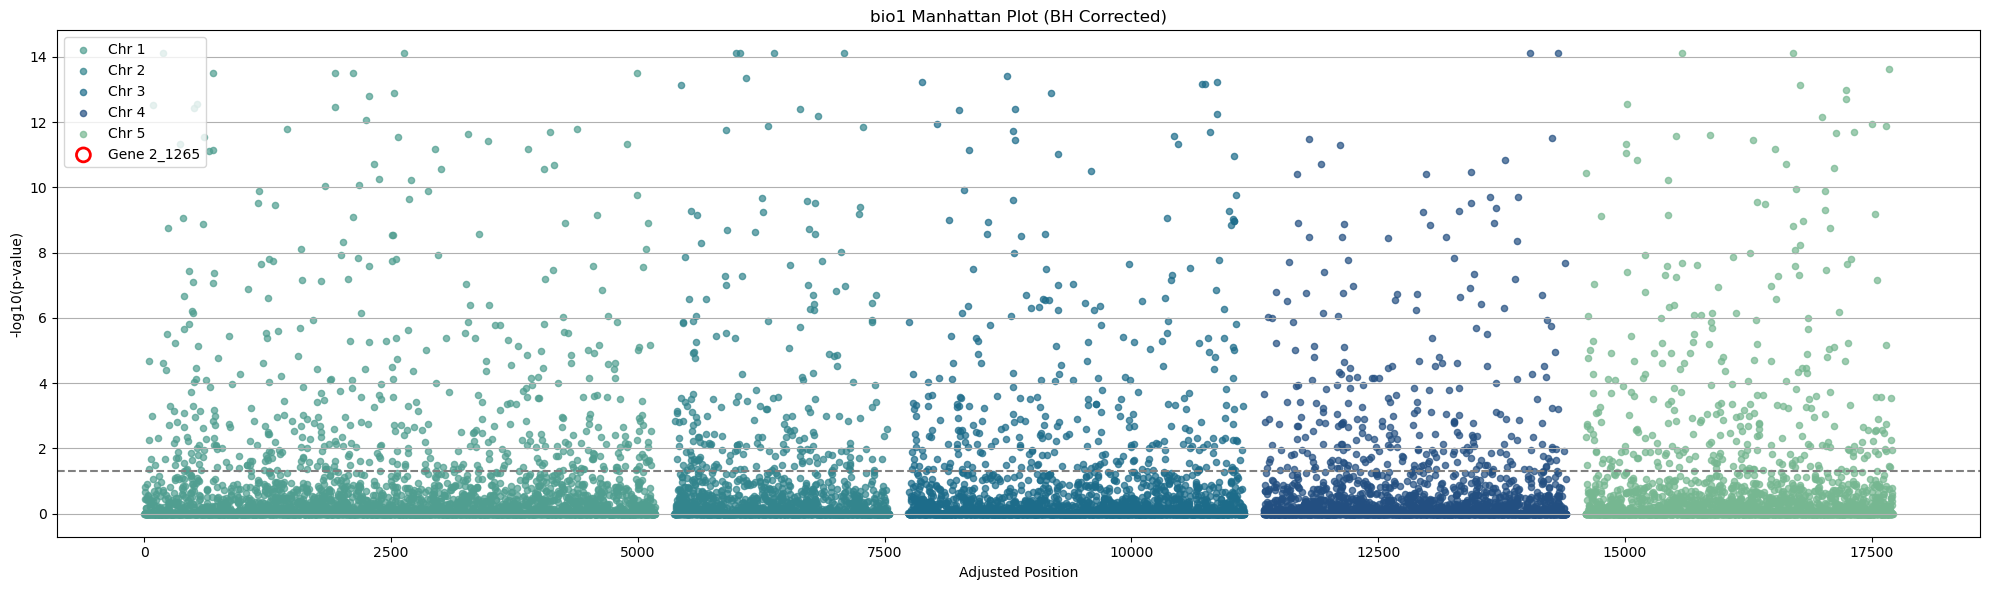

In [678]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.multitest import multipletests

# Assuming you have your DataFrame named wza_results_lfmm_bio1_pol7

# Apply the BH correction on the 'Z_pVal' column
wza_results_lfmm_bio1_pol7['BH_corrected_p'] = multipletests(wza_results_lfmm_bio1_pol7['Z_no_spline'], method='fdr_bh')[1]

# Significance threshold using BH method
threshold_value = 0.05
threshold = -np.log10(threshold_value)
biovar = 'bio1'

# Create chrom_pos in wza_lfmm by combining 'chrom' and 'pos'
wza_results_lfmm_bio1_pol7['chrom_pos'] = wza_results_lfmm_bio1_pol7['chrom'].astype(str) + '_' + wza_results_lfmm_bio1_pol7['pos'].astype(str)

# Copy the relevant columns for plotting
df = wza_results_lfmm_bio1_pol7[['BH_corrected_p', 'pos', 'chrom', 'chrom_pos']].copy()

# Parse chromosome number and position
df['chromosome'] = df['chrom']
df['position'] = df['pos']
df['-log10(pvalue)'] = -np.log10(df['BH_corrected_p'])

# Define colors for each chromosome
colors = sns.color_palette("crest", n_colors=5)

# Calculate chromosome offsets to prevent overlap
chromosome_offsets = {}
offset = 0
for chrom in sorted(df['chromosome'].unique()):
    chromosome_offsets[chrom] = offset
    max_position = df[df['chromosome'] == chrom]['position'].max()
    offset += max_position + 200  # Add buffer to prevent overlap

# Apply offsets to the position
df['adjusted_position'] = df.apply(lambda row: row['position'] + chromosome_offsets[row['chromosome']], axis=1)

# Create the Manhattan plot
plt.figure(figsize=(20, 6))

# Plot each chromosome separately
for chrom in sorted(df['chromosome'].unique()):
    subset = df[df['chromosome'] == chrom]
    plt.scatter(
        subset['adjusted_position'],
        subset['-log10(pvalue)'],
        alpha=0.7, 
        c=colors[chrom % len(colors)], 
        label=f'Chr {chrom}',
        s=20
    )

# Aesthetics
plt.xlabel('Adjusted Position')
plt.ylabel('-log10(p-value)')
plt.title(f'{biovar} Manhattan Plot (BH Corrected)')
plt.grid(axis='y')

# Add a threshold line for significance
plt.axhline(y=threshold, color='grey', linestyle='dashed')

# Identify significant blocks in wza_lfmm
significant_blocks = df[df['-log10(pvalue)'] >= threshold]

# Highlight specific genes if needed
genes = ['2_1265']  # List of specific genes to highlight
for gene in genes:
    chrom, pos = map(int, gene.split('_'))
    subset_gene = df[(df['chromosome'] == chrom) & (df['position'] == pos)]
    if not subset_gene.empty:
        plt.scatter(
            subset_gene['adjusted_position'],
            subset_gene['-log10(pvalue)'],
            edgecolor='red',
            linewidth=2,
            facecolor='none',
            s=100,
            label=f'Gene {gene}'
        )

plt.tight_layout()
plt.legend()
plt.show()


/home/tbellagio/miniforge3/envs/pipeline_snakemake/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_259589/432233608.py:41: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


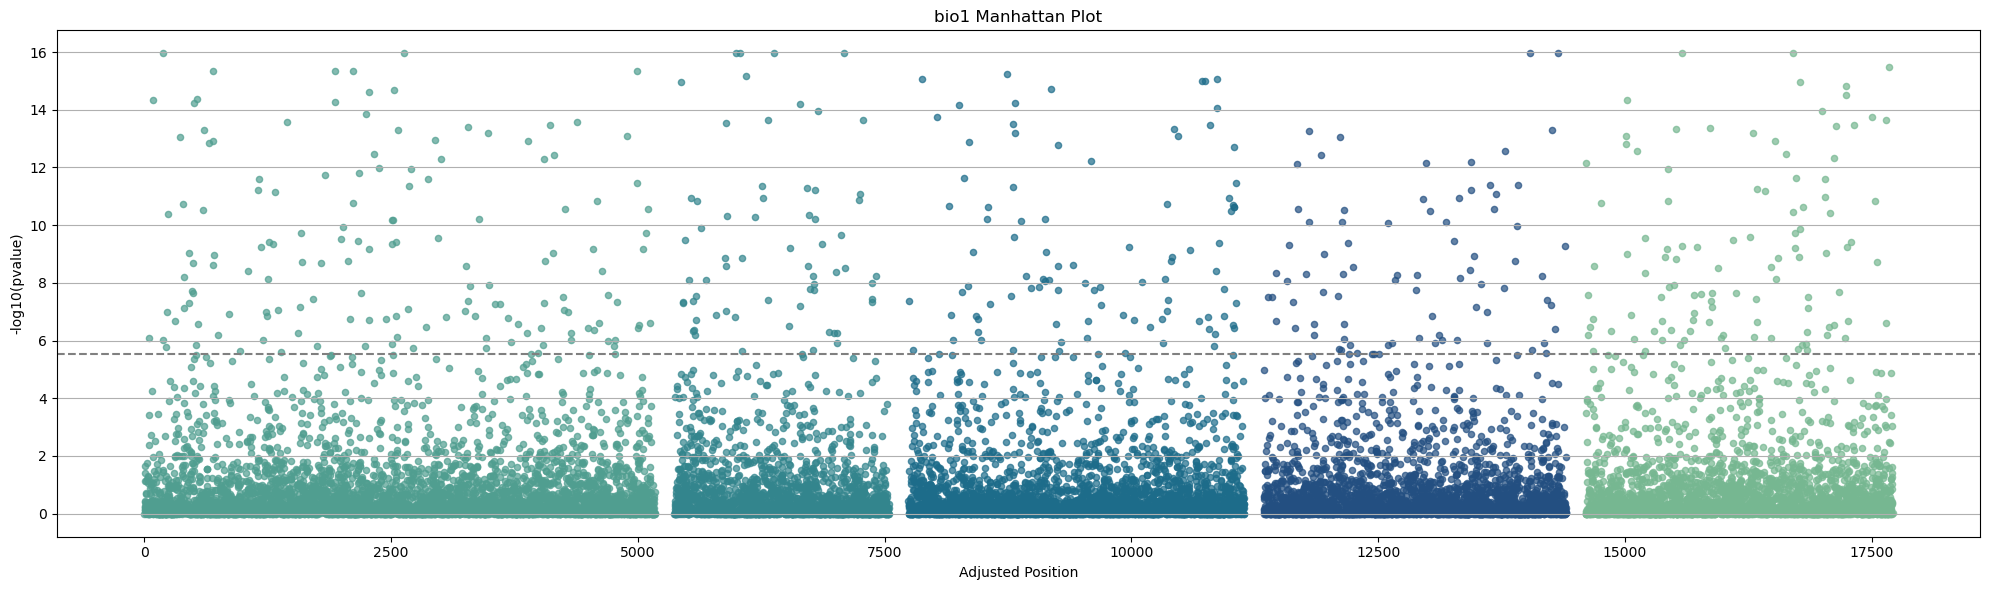

In [679]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Significance threshold
threshold_value = 0.05 / len(wza_results_lfmm_bio1_pol7)
threshold = -np.log10(threshold_value)
biovar = 'bio1'

# Create chrom_pos in wza_lfmm by combining 'chrom' and 'pos'
wza_results_lfmm_bio1_pol7['chrom_pos'] = wza_results_lfmm_bio1_pol7['chrom'].astype(str) + '_' + wza_results_lfmm_bio1_pol7['pos'].astype(str)

# Copy the relevant columns for plotting
df = wza_results_lfmm_bio1_pol7[['Z_no_spline', 'pos', 'chrom', 'chrom_pos']].copy()

# Parse chromosome number and position
df['chromosome'] = df['chrom']
df['position'] = df['pos']
df['-log10(pvalue)'] = -np.log10(df['Z_no_spline'])

# Define colors for each chromosome
colors = sns.color_palette("crest", n_colors=5)

# Calculate chromosome offsets to prevent overlap
chromosome_offsets = {}
offset = 0
for chrom in sorted(df['chromosome'].unique()):
    chromosome_offsets[chrom] = offset
    max_position = df[df['chromosome'] == chrom]['position'].max()
    offset += max_position + 200  # Add buffer to prevent overlap

# Apply offsets to the position
df['adjusted_position'] = df.apply(lambda row: row['position'] + chromosome_offsets[row['chromosome']], axis=1)

# Create the Manhattan plot
plt.figure(figsize=(20, 6))

# Plot each chromosome separately
for chrom in sorted(df['chromosome'].unique()):
    subset = df[df['chromosome'] == chrom]
    plt.scatter(
        subset['adjusted_position'],
        subset['-log10(pvalue)'],
        alpha=0.7, 
        c=colors[chrom % len(colors)], 
        label=f'Chr {chrom}',
        s=20
    )

# Aesthetics
plt.xlabel('Adjusted Position')
plt.ylabel('-log10(pvalue)')
plt.title(f'{biovar} Manhattan Plot')
plt.grid(axis='y')

# Add a threshold line for significance
plt.axhline(y=threshold, color='grey', linestyle='dashed')

# Identify significant blocks in wza_lfmm
significant_blocks = df[df['-log10(pvalue)'] >= threshold]


# Highlight specific genes if needed
genes = ['2_1265']  # List of specific genes to highlight
for gene in genes:
    chrom, pos = map(int, gene.split('_'))
    subset_gene = df[(df['chromosome'] == chrom) & (df['position'] == pos)]
    if not subset_gene.empty:
        plt.scatter(
            subset_gene['adjusted_position'],
            subset_gene['-log10(pvalue)'],
            edgecolor='red',
            linewidth=2,
            facecolor='none',
            s=100,
            label=f'Gene {gene}'
        )

plt.tight_layout()
plt.show()


/tmp/ipykernel_3972733/450657511.py:41: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


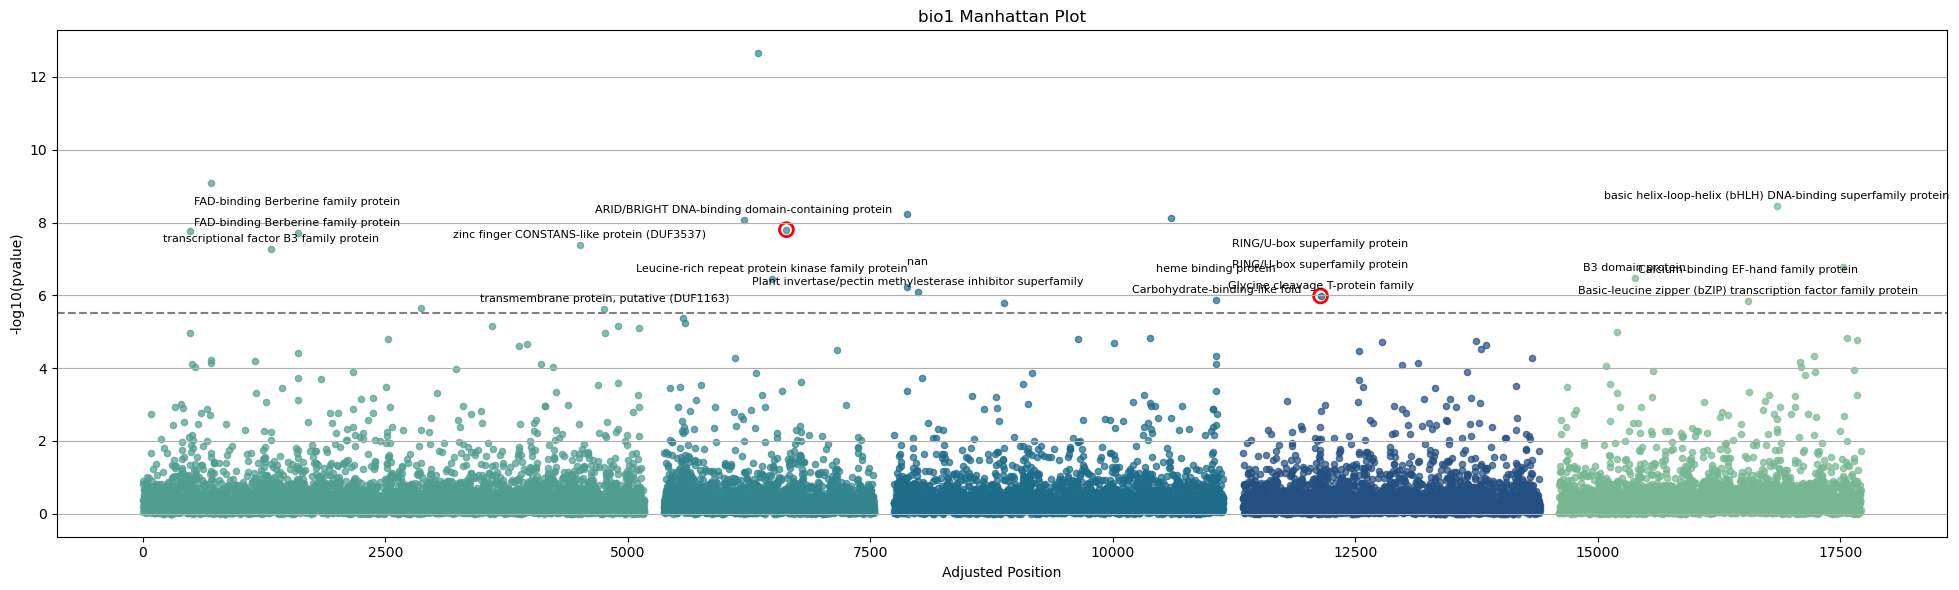

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Significance threshold
threshold_value = 0.05 / len(wza_lfmm)
threshold = -np.log10(threshold_value)
biovar = 'bio1'

# Create chrom_pos in wza_lfmm by combining 'chrom' and 'pos'
wza_lfmm['chrom_pos'] = wza_lfmm['chrom'].astype(str) + '_' + wza_lfmm['pos'].astype(str)

# Copy the relevant columns for plotting
df = wza_lfmm[['Z_pVal', 'pos', 'chrom', 'chrom_pos']].copy()

# Parse chromosome number and position
df['chromosome'] = df['chrom']
df['position'] = df['pos']
df['-log10(pvalue)'] = -np.log10(df['Z_pVal'])

# Define colors for each chromosome
colors = sns.color_palette("crest", n_colors=5)

# Calculate chromosome offsets to prevent overlap
chromosome_offsets = {}
offset = 0
for chrom in sorted(df['chromosome'].unique()):
    chromosome_offsets[chrom] = offset
    max_position = df[df['chromosome'] == chrom]['position'].max()
    offset += max_position + 200  # Add buffer to prevent overlap

# Apply offsets to the position
df['adjusted_position'] = df.apply(lambda row: row['position'] + chromosome_offsets[row['chromosome']], axis=1)

# Create the Manhattan plot
plt.figure(figsize=(20, 6))

# Plot each chromosome separately
for chrom in sorted(df['chromosome'].unique()):
    subset = df[df['chromosome'] == chrom]
    plt.scatter(
        subset['adjusted_position'],
        subset['-log10(pvalue)'],
        alpha=0.7, 
        c=colors[chrom % len(colors)], 
        label=f'Chr {chrom}',
        s=20
    )

# Aesthetics
plt.xlabel('Adjusted Position')
plt.ylabel('-log10(pvalue)')
plt.title(f'{biovar} Manhattan Plot')
plt.grid(axis='y')

# Add a threshold line for significance
plt.axhline(y=threshold, color='grey', linestyle='dashed')

# Identify significant blocks in wza_lfmm
significant_blocks = df[df['-log10(pvalue)'] >= threshold]

# Merge significant blocks with the annotation dataframe based on chrom_pos and block
annotated_blocks = significant_blocks.merge(small, left_on='chrom_pos', right_on='block', how='inner')

# Annotate the significant points with 'description1' and space annotations vertically
for chrom_pos, group in annotated_blocks.groupby('chrom_pos'):
    # Sort the group to ensure consistent spacing
    group = group.sort_values(by='description1')
    vertical_offset = 0  # Start the vertical offset at 0
    for i, row in group.iterrows():
        plt.annotate(
            row['description1'], 
            (row['adjusted_position'], row['-log10(pvalue)']),
            textcoords="offset points",  # Specify the offset point for the text
            xytext=(0, 5 + vertical_offset),  # Increment vertical offset for each annotation
            ha='center',    # Align horizontally to center
            fontsize=8,
            color='black'
        )
        vertical_offset += 15  # Increase vertical offset for the next annotation

# Highlight specific genes if needed
genes = ['2_1265', '4_801']  # List of specific genes to highlight
for gene in genes:
    chrom, pos = map(int, gene.split('_'))
    subset_gene = df[(df['chromosome'] == chrom) & (df['position'] == pos)]
    if not subset_gene.empty:
        plt.scatter(
            subset_gene['adjusted_position'],
            subset_gene['-log10(pvalue)'],
            edgecolor='red',
            linewidth=2,
            facecolor='none',
            s=100,
            label=f'Gene {gene}'
        )

plt.tight_layout()
plt.show()


/tmp/ipykernel_3972733/1450895180.py:41: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


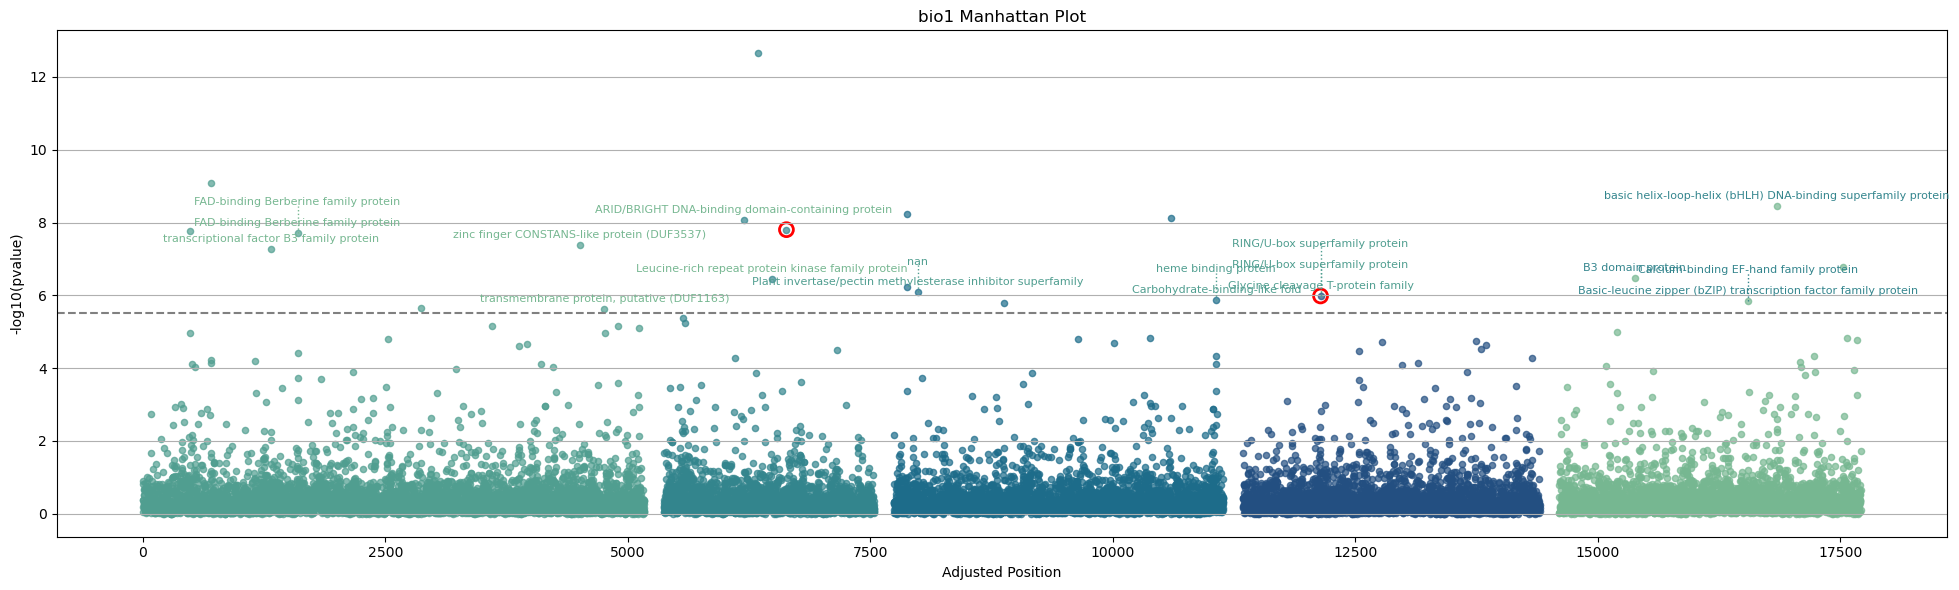

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Significance threshold
threshold_value = 0.05 / len(wza_lfmm)
threshold = -np.log10(threshold_value)
biovar = 'bio1'

# Create chrom_pos in wza_lfmm by combining 'chrom' and 'pos'
wza_lfmm['chrom_pos'] = wza_lfmm['chrom'].astype(str) + '_' + wza_lfmm['pos'].astype(str)

# Copy the relevant columns for plotting
df = wza_lfmm[['Z_pVal', 'pos', 'chrom', 'chrom_pos']].copy()

# Parse chromosome number and position
df['chromosome'] = df['chrom']
df['position'] = df['pos']
df['-log10(pvalue)'] = -np.log10(df['Z_pVal'])

# Define colors for each chromosome or block
colors = sns.color_palette("crest", n_colors=len(df['chromosome'].unique()))  # Assign a unique color per chromosome

# Calculate chromosome offsets to prevent overlap
chromosome_offsets = {}
offset = 0
for chrom in sorted(df['chromosome'].unique()):
    chromosome_offsets[chrom] = offset
    max_position = df[df['chromosome'] == chrom]['position'].max()
    offset += max_position + 200  # Add buffer to prevent overlap

# Apply offsets to the position
df['adjusted_position'] = df.apply(lambda row: row['position'] + chromosome_offsets[row['chromosome']], axis=1)

# Create the Manhattan plot
plt.figure(figsize=(20, 6))

# Plot each chromosome separately
for chrom in sorted(df['chromosome'].unique()):
    subset = df[df['chromosome'] == chrom]
    plt.scatter(
        subset['adjusted_position'],
        subset['-log10(pvalue)'],
        alpha=0.7, 
        c=colors[chrom % len(colors)], 
        label=f'Chr {chrom}',
        s=20
    )

# Aesthetics
plt.xlabel('Adjusted Position')
plt.ylabel('-log10(pvalue)')
plt.title(f'{biovar} Manhattan Plot')
plt.grid(axis='y')

# Add a threshold line for significance
plt.axhline(y=threshold, color='grey', linestyle='dashed')

# Identify significant blocks in wza_lfmm
significant_blocks = df[df['-log10(pvalue)'] >= threshold]

# Merge significant blocks with the annotation dataframe based on chrom_pos and block
annotated_blocks = significant_blocks.merge(small, left_on='chrom_pos', right_on='block', how='inner')

# Annotate the significant points with 'description1', space annotations, and color-code them
for chrom_pos, group in annotated_blocks.groupby('chrom_pos'):
    group = group.sort_values(by='description1')
    vertical_offset = 0  # Start the vertical offset at 0
    
    # Color for this block
    color = colors[chromosome_offsets[group['chromosome'].iloc[0]] % len(colors)]

    for i, row in group.iterrows():
        # Add the annotation
        plt.annotate(
            row['description1'], 
            (row['adjusted_position'], row['-log10(pvalue)']),
            textcoords="offset points",  
            xytext=(0, 5 + vertical_offset),  # Offset vertically for each annotation
            ha='center',
            fontsize=8,
            color=color  # Use the same color for annotation
        )
        
        # Draw a line connecting the point to the annotation
        plt.plot(
            [row['adjusted_position'], row['adjusted_position']],  # X coordinates (same X)
            [row['-log10(pvalue)'], row['-log10(pvalue)'] + (vertical_offset / 20)],  # Y coordinates
            color=color, linewidth=1, linestyle='dotted'
        )
        
        vertical_offset += 15  # Increase vertical offset for the next annotation

# Highlight specific genes if needed
genes = ['2_1265', '4_801']  # List of specific genes to highlight
for gene in genes:
    chrom, pos = map(int, gene.split('_'))
    subset_gene = df[(df['chromosome'] == chrom) & (df['position'] == pos)]
    if not subset_gene.empty:
        plt.scatter(
            subset_gene['adjusted_position'],
            subset_gene['-log10(pvalue)'],
            edgecolor='red',
            linewidth=2,
            facecolor='none',
            s=100,
            label=f'Gene {gene}'
        )

plt.tight_layout()
plt.show()


/tmp/ipykernel_3972733/3243139160.py:39: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


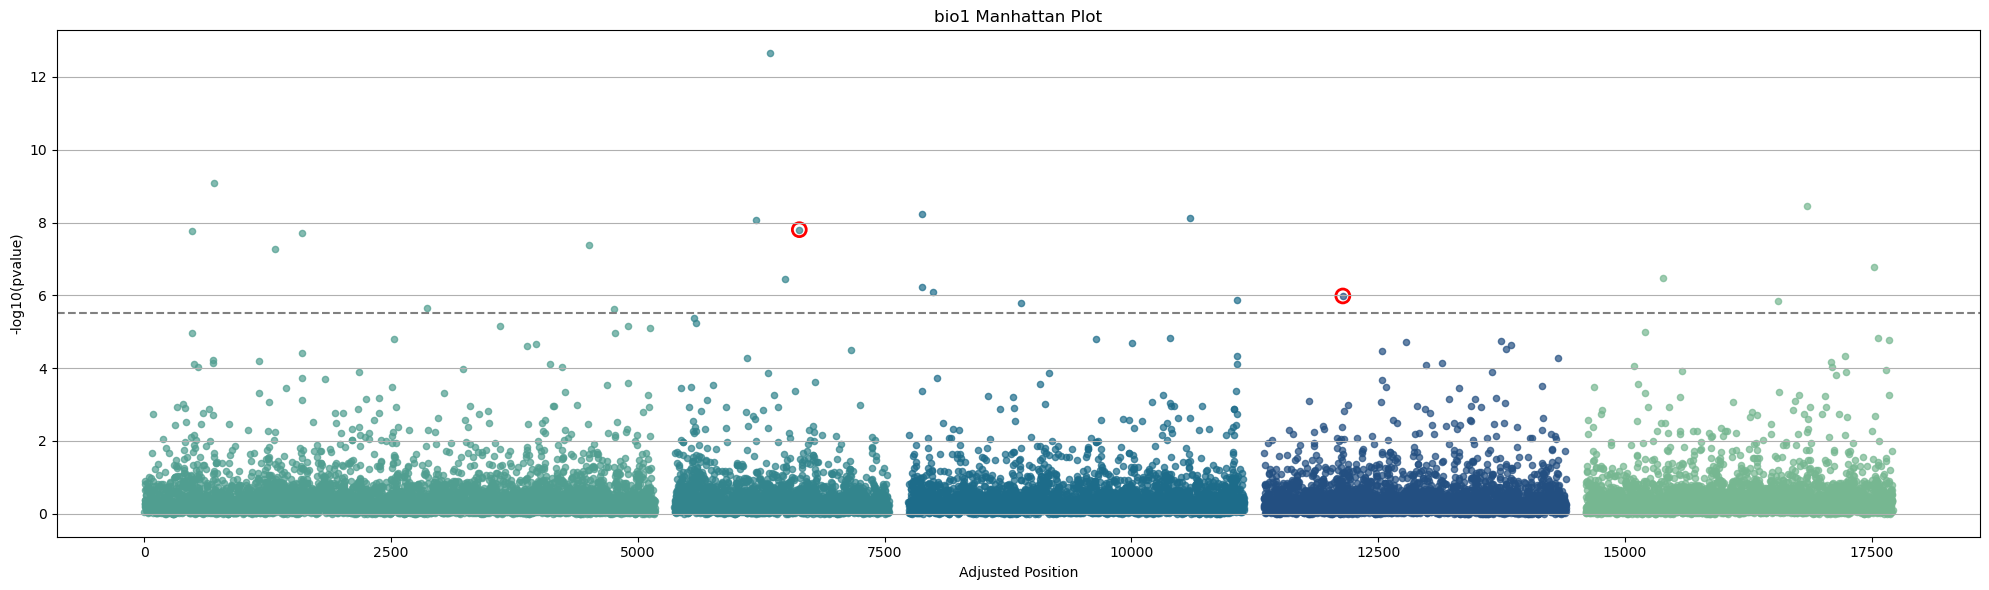

In [27]:
threshold_value = 0.05 / len(wza_lfmm)
biovar='bio1'
#sm.qqplot(pvalues['pvalue'], line ='45') 
#py.show() 

df = wza_lfmm[['Z_pVal','pos','chrom']].copy()


# Parsing chromosome number and position
df['chromosome'] = df['chrom']
df['position'] = df['pos']
df['-log10(pvalue)'] = -np.log10(df['Z_pVal'])

colors = sns.color_palette("crest", n_colors = 5)

# Calculate the offset for each chromosome to prevent overlap
chromosome_offsets = {}
offset = 0
for chrom in sorted(df['chromosome'].unique()):
    chromosome_offsets[chrom] = offset
    max_position = df[df['chromosome'] == chrom]['position'].max()
    offset += max_position + 200  # Buffer to prevent overlap

# Apply offsets to positions
df['adjusted_position'] = df.apply(lambda row: row['position'] + chromosome_offsets[row['chromosome']], axis=1)

# Normalize sizes for better visualization
size_transform = 2  # Adjust this factor as needed


# Create a color map based on `n_est`
#df['color'] = df['n_est'].map(lambda x: cmap(norm(x)))

# Creating the Manhattan plot
plt.figure(figsize=(20, 6))

for chrom in sorted(df['chromosome'].unique()):
    subset = df[df['chromosome'] == chrom]
    plt.scatter(
        subset['adjusted_position'],
        subset['-log10(pvalue)'],
        alpha=0.7,  # Transparency for better visibility
        c=colors[chrom % len(colors)], 
        label=f'Chr {chrom}',
            s= 20)

# Aesthetics
plt.xlabel('Adjusted Position')
plt.ylabel('-log10(pvalue)')
plt.title(f'{biovar} Manhattan Plot')  # Set the title
plt.grid(axis='y')


#genes = ['2_199', '3_2730', '5_2244']
genes = ['2_1265', '4_801']
# Add circles around the specific genes
for gene in genes:
    chrom, pos = map(int, gene.split('_'))
    subset_gene = df[(df['chromosome'] == chrom) & (df['position'] == pos)]
    if not subset_gene.empty:
        plt.scatter(
            subset_gene['adjusted_position'],
            subset_gene['-log10(pvalue)'],
            edgecolor='red',  # Color of the edge of the circle
            linewidth=2,      # Width of the edge line
            facecolor='none', # Facecolor of the circle (None means transparent)
            s=100,            # Size of the circle
            label=f'Gene {gene}'
        )
# Create a legend for the number of estimated lineages
#handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(norm(n)), markersize=10, label=f'Lineages {n}') for n in sorted(n_est_unique)]
#plt.legend(handles=handles, title="Estimated Lineages", bbox_to_anchor=(1.05, 1), loc='upper left')

# Threshold line
threshold = -np.log10(threshold_value)
plt.axhline(y=threshold, color='grey', linestyle='dashed')

# Show the plot
plt.tight_layout()
plt.show()


In [51]:
wza_kendall = pd.read_csv('wza_kendalltau_results_bio1.csv').reset_index()

In [52]:
wza_kendall['chrom'] = wza_kendall['gene'].str.split('_').str[0].astype(int)
wza_kendall['pos'] = wza_kendall['gene'].str.split('_').str[1].astype(int)

In [53]:
threshold_value = 0.05 / len(wza_kendall)

In [54]:
wza_kendall[wza_kendall['Z_pVal']< threshold_value].to_csv('wza_kendall_significant_blocks.csv',index=None)

In [ ]:
wza_kendall

In [ ]:
gene - the name of the window
SNPs - the number of SNPs in this window
hits - the number of SNPs in the 99th percentile (not used for anything, just good to know)
Z - the Z score calculated for the gene
top_candidate_p - the result of the top-candidate method of Yeaman et al (2016 - Science)
LA - an indicator of whether the gene is causal for local adaptation
position - the average position of all SNPs in the window
Z_pVal - the p-value of the Z score (This is the WZA score)


/tmp/ipykernel_894693/1995763944.py:1: RuntimeWarning: divide by zero encountered in log10
  observed_quantiles = -np.log10(np.sort(wza_kendall['Z_pVal'].values))


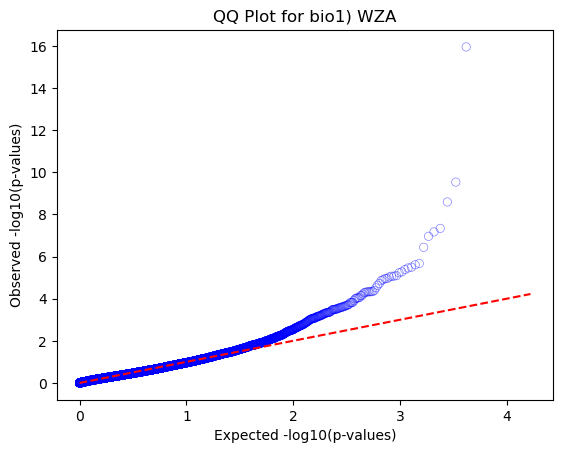

In [48]:
observed_quantiles = -np.log10(np.sort(wza_kendall['Z_pVal'].values))

# Expected quantiles from the uniform distribution
expected_quantiles = -np.log10(np.linspace(1 / len(wza_kendall), 1, len(wza_kendall)))

# QQ plot
sns.scatterplot(x = expected_quantiles, y = observed_quantiles, edgecolor='b', facecolor='none', alpha=0.5)
plt.plot([min(expected_quantiles), max(expected_quantiles)], [min(expected_quantiles), max(expected_quantiles)], 'r--')

plt.xlabel("Expected -log10(p-values)")
plt.ylabel("Observed -log10(p-values)")
plt.title(f'QQ Plot for {biovar}) WZA')

plt.show()

/home/tbellagio/miniforge3/envs/pipeline_snakemake/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_894693/2348446781.py:39: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


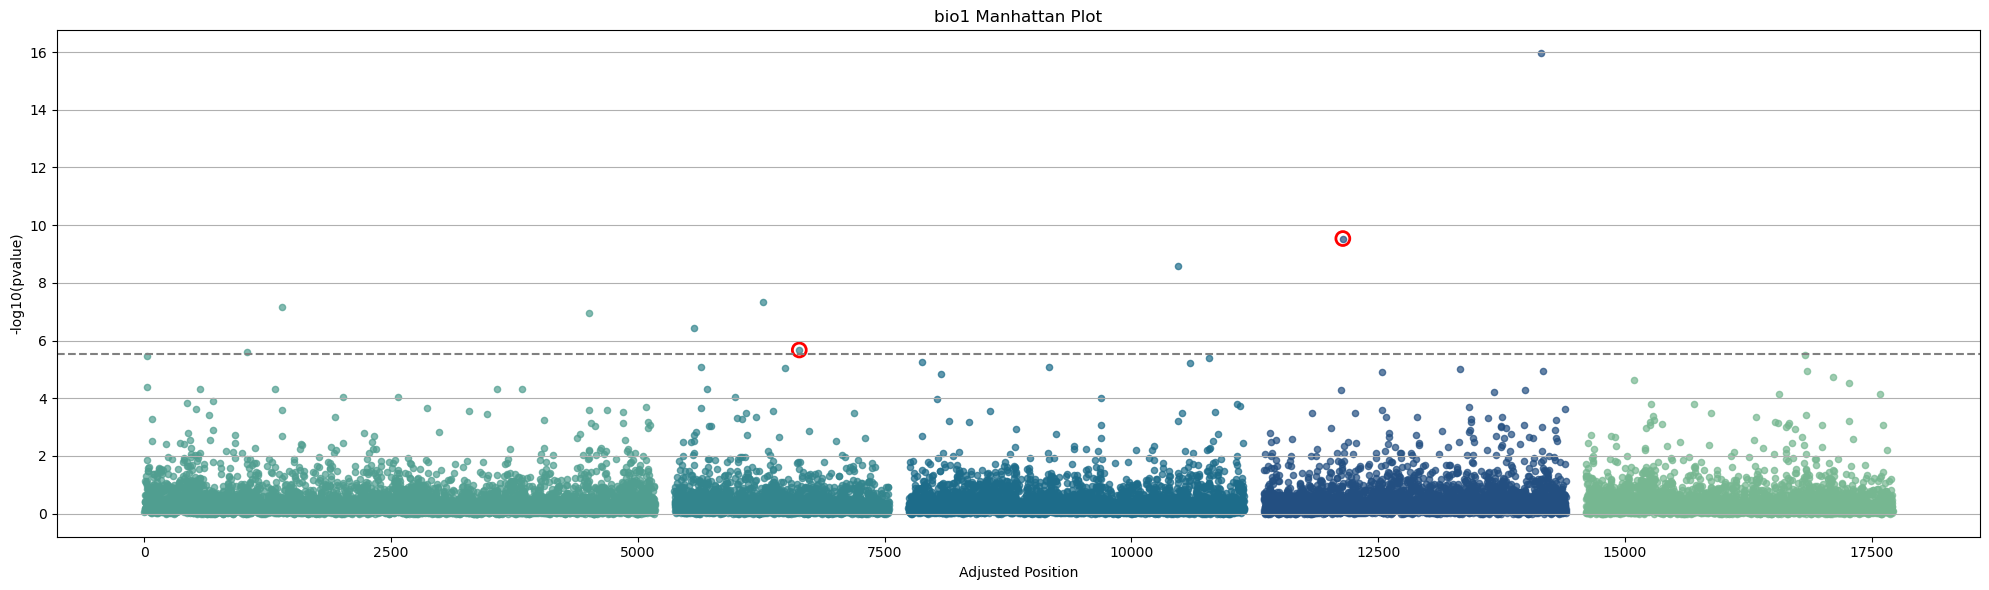

In [57]:
threshold_value = 0.05 / len(wza_kendall)
biovar='bio1'
#sm.qqplot(pvalues['pvalue'], line ='45') 
#py.show() 

df = wza_kendall[['Z_pVal','pos','chrom']].copy()


# Parsing chromosome number and position
df['chromosome'] = df['chrom']
df['position'] = df['pos']
df['-log10(pvalue)'] = -np.log10(df['Z_pVal'])

colors = sns.color_palette("crest", n_colors = 5)

# Calculate the offset for each chromosome to prevent overlap
chromosome_offsets = {}
offset = 0
for chrom in sorted(df['chromosome'].unique()):
    chromosome_offsets[chrom] = offset
    max_position = df[df['chromosome'] == chrom]['position'].max()
    offset += max_position + 200  # Buffer to prevent overlap

# Apply offsets to positions
df['adjusted_position'] = df.apply(lambda row: row['position'] + chromosome_offsets[row['chromosome']], axis=1)

# Normalize sizes for better visualization
size_transform = 2  # Adjust this factor as needed


# Create a color map based on `n_est`
#df['color'] = df['n_est'].map(lambda x: cmap(norm(x)))

# Creating the Manhattan plot
plt.figure(figsize=(20, 6))

for chrom in sorted(df['chromosome'].unique()):
    subset = df[df['chromosome'] == chrom]
    plt.scatter(
        subset['adjusted_position'],
        subset['-log10(pvalue)'],
        alpha=0.7,  # Transparency for better visibility
        c=colors[chrom % len(colors)], 
        label=f'Chr {chrom}',
            s= 20)

# Aesthetics
plt.xlabel('Adjusted Position')
plt.ylabel('-log10(pvalue)')
plt.title(f'{biovar} Manhattan Plot')  # Set the title
plt.grid(axis='y')

# Create a legend for the number of estimated lineages
#handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(norm(n)), markersize=10, label=f'Lineages {n}') for n in sorted(n_est_unique)]
#plt.legend(handles=handles, title="Estimated Lineages", bbox_to_anchor=(1.05, 1), loc='upper left')
#genes = ['2_199', '3_2730', '5_2244']
genes = ['2_1265', '4_801']
# Add circles around the specific genes
for gene in genes:
    chrom, pos = map(int, gene.split('_'))
    subset_gene = df[(df['chromosome'] == chrom) & (df['position'] == pos)]
    if not subset_gene.empty:
        plt.scatter(
            subset_gene['adjusted_position'],
            subset_gene['-log10(pvalue)'],
            edgecolor='red',  # Color of the edge of the circle
            linewidth=2,      # Width of the edge line
            facecolor='none', # Facecolor of the circle (None means transparent)
            s=100,            # Size of the circle
            label=f'Gene {gene}'
        )


# Threshold line
threshold = -np.log10(threshold_value)
plt.axhline(y=threshold, color='grey', linestyle='dashed')

# Show the plot
plt.tight_layout()
plt.show()


/tmp/ipykernel_3175312/2368688080.py:31: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)


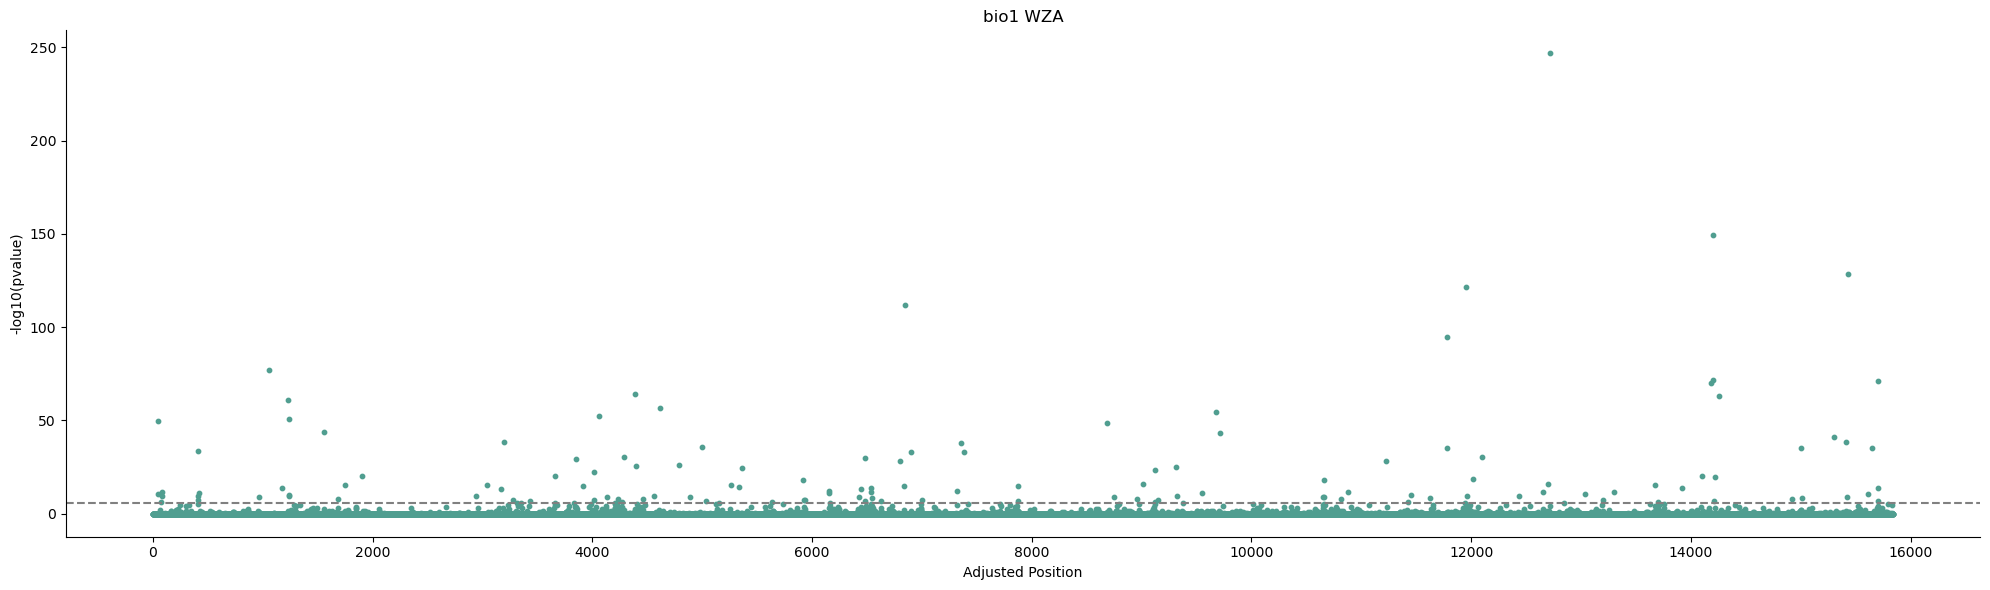

In [50]:
threshold_value = 0.05 / len(wza)
biovar='bio1'
#sm.qqplot(pvalues['pvalue'], line ='45') 
#py.show() 

df = wza[['top_candidate_p', 'index']].copy()

colors = sns.color_palette("crest", n_colors = 5)

# Parsing chromosome number and position
df['chromosome'] = 1
df['position'] = df['index']
df['-log10(pvalue)'] = -np.log10(df['top_candidate_p'])

# Calculate the offset for each chromosome to prevent overlap
chromosome_offsets = {}
offset = 0
for chrom in sorted(df['chromosome'].unique()):
    chromosome_offsets[chrom] = offset
    max_position = df[df['chromosome'] == chrom]['position'].max()
    offset += max_position + 1000000  # Adding 1 million as a buffer between chromosomes

# Apply offsets to positions
df['adjusted_position'] = df.apply(lambda row: row['position'] + chromosome_offsets[row['chromosome']], axis=1)

# Creating the Manhattan plot
plt.figure(figsize=(20, 6))

for chrom in sorted(df['chromosome'].unique()):
    subset = df[df['chromosome'] == chrom]
    plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)

# Aesthetics
plt.xlabel('Adjusted Position')
plt.ylabel('-log10(pvalue)')
#plt.title('Manhattan Plot')
#plt.grid(axis='y')
#plt.legend(title="Chromosome", bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)  # Remove the top spine
ax.spines['right'].set_visible(False)
# Threshold line (optional)
threshold = -np.log10(threshold_value)
plt.axhline(y=threshold, color='grey', linestyle='dashed')
plt.title(f'{biovar} WZA')  # Set the title

# Show the plot
plt.tight_layout()
plt.savefig(f'manhattan_{biovar}.png')
plt.show()